# 0.0 IMPORTS

In [4]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt 
import sweetviz as sv
import scikitplot as skplt
import lightgbm as lgb
import warnings
import pickle

from xgboost import XGBClassifier
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from boruta import BorutaPy

warnings.filterwarnings('ignore')

## 0.1 Loading Data

In [5]:
path = 'C:/Users/edils/repos/pa004_health_insurance/data/'

In [6]:
df_raw = pd.read_csv(path + 'train.csv')

In [7]:
y_raw = df_raw['Response']
df_raw = df_raw.drop(columns='Response')

In [8]:
df_raw_splitted, X_test, y_raw_splitted, y_test = ms.train_test_split(df_raw, y_raw, test_size=0.2, random_state=42)

In [9]:
df_raw = df_raw_splitted
df_raw['Response'] = y_raw_splitted

In [10]:
df_raw

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
332803,332804,Female,39,1,15.0,0,1-2 Year,Yes,52906.0,55.0,227,1
116248,116249,Male,38,1,11.0,0,1-2 Year,Yes,23038.0,26.0,29,0
255005,255006,Male,22,1,30.0,1,< 1 Year,No,45318.0,152.0,166,0
317474,317475,Female,23,1,41.0,1,< 1 Year,No,29132.0,151.0,277,0
344212,344213,Male,56,1,48.0,0,> 2 Years,Yes,2630.0,154.0,155,0
...,...,...,...,...,...,...,...,...,...,...,...,...
259178,259179,Female,24,1,36.0,1,< 1 Year,No,22575.0,152.0,287,0
365838,365839,Male,56,1,35.0,0,1-2 Year,Yes,41287.0,124.0,298,0
131932,131933,Female,22,1,2.0,0,< 1 Year,Yes,18857.0,152.0,76,0
146867,146868,Male,44,1,32.0,1,1-2 Year,Yes,2630.0,156.0,51,0


## 0.2 Helper Functions

In [11]:
def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).to_numpy()
  n = cm.sum()
  r, k = cm.shape

  chi2 = stats.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def precision_at_k(df8, k, yhat):
    df8['id'] = df8.index + 1
    df8['score'] = yhat[:,1]
    df8 = df8.sort_values(by='score', ascending=False)
    df8 = df8.reset_index(drop=True)
    dfk = df8.iloc[:k, :]
    soma_total = dfk['response'].shape[0]
    soma_acertos = dfk['response'].sum()
    precision_at_k = soma_acertos/soma_total
    return precision_at_k

def recall_at_k(df8, k, yhat):
    df8['id'] = df8.index + 1
    df8['score'] = yhat[:,1]
    df8 = df8.sort_values(by='score', ascending=False)
    df8 = df8.reset_index(drop=True)
    dfk = df8.iloc[:k, :]
    soma_total = (df8['response'] == 1).sum()
    soma_acertos = dfk['response'].sum()
    recall_at_k = soma_acertos/soma_total
    return recall_at_k

def model_metrics(model_name, y, yhat, x_validation):
    precision = precision_at_k(x_validation, 4000, yhat)
    recall = recall_at_k(x_validation, 4000, yhat)
    f1_score = 2*(precision*recall)/(precision+recall)
    acc_score = mt.top_k_accuracy_score(y, yhat[:,1], k=1)
    auc_score = mt.roc_auc_score(y, yhat[:,1])
    
    return pd.DataFrame({'Model Name': model_name,
                         'Precisão at K': precision,
                         'Recall at K': recall,
                         'F1 at K': f1_score,
                         'Acurácia at K': acc_score,
                         'ROC AUC at K': auc_score}, index=[0])

def cross_validation(X, y, k_folds, model_name, model):

    df_list = []
    df_concat = pd.DataFrame()
    
    for k in range(k_folds):
        
        x_train_cv, x_val_cv, y_train_cv, y_val_cv = ms.train_test_split(X, y, test_size=0.2, random_state=k)

        x_train_cv = x_train_cv.loc[:,cols_selected]
        x_val_cv = x_val_cv.loc[:,cols_selected]

        x_validation_cv = x_val_cv.copy()
        x_validation_cv['response'] = y_val_cv.copy()

        #model
        m = model

        #training
        m.fit(x_train_cv, y_train_cv)

        #prediction
        yhat = m.predict_proba(x_val_cv)

        #performance
        df_metrics = model_metrics(model_name, y_val_cv, yhat, x_validation_cv)
        df_list.append(df_metrics)
        
    
    df_concat = pd.concat(df_list, ignore_index=True)
    
    return df_concat

def rename_columns(df1):
    cols_old = df1.columns

    cols_new = []
    cols_new = cols_old.map(lambda x: inflection.underscore(x))

    df1.columns = cols_new
    
    return df1

def rename_categorical(df2):

    #Renaming vehicle_age lines
    #< 1 Year = new || 1-2 Years = used || >2 Years = old
    df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'old' if x == '> 2 Years' else 'used' if x == '1-2 Year' else 'new')

    #Renaming vehicle_damage
    df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

    #Renaming gender #Male = 1, Female = 0
    df2['gender'] = df2['gender'].apply(lambda x: 1 if x=='Male' else 0)
    
    return df2

def data_encoding(df5):

    #vehicle_age - Label Encoder
    df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 0 if x == 'new' else 1 if x == 'used' else 2)

    #region_code - Frequency Encoding
    fe_region_code = df5.groupby('region_code').size() / len (df5)
    df5['region_code'] = df5['region_code'].map(fe_region_code)
    #pickle.dump(fe_region_code, open('C:/Users/edils/repos/pa004_health_insurance/src/features/fe_region_code_scaler.pkl','wb'))

    #policy_sales_channel'
    fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len (df5)
    df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
    #pickle.dump(fe_policy_sales_channel, open('C:/Users/edils/repos/pa004_health_insurance/src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))
    
    
    return df5

def data_rescalling(df5):

    mms = MinMaxScaler()
    rb = RobustScaler()

    #age 
    df5['age'] = mms.fit_transform(df5['age'].values.reshape(-1,1))
    #pickle.dump(mms, open('C:/Users/edils/repos/pa004_health_insurance/src/features/age_scaler.pkl', 'wb'))
    

    #annual_premium
    df5['annual_premium'] = rb.fit_transform(df5['annual_premium'].values.reshape(-1,1))
    #pickle.dump(rb, open('C:/Users/edils/repos/pa004_health_insurance/src/features/annual_premium_scaler.pkl', 'wb'))
    

    #vintage
    df5['vintage'] = mms.fit_transform(df5['vintage'].values.reshape(-1,1))
    #pickle.dump(mms, open('C:/Users/edils/repos/pa004_health_insurance/src/features/vintage_scaler.pkl', 'wb'))
    

    return df5

# 1.0 DATA DESCRIPTION

In [12]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [13]:
df1 = rename_columns(df1)

## 1.2 Data Dimension

In [14]:
df1.shape

(304887, 12)

## 1.3 Data Types

In [15]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA 

In [16]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Descriptive Statistics

In [17]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1 Numerical Attributes

In [18]:
#Dispersion - std, min, max, range, skew, kurtosis + #Central Tendency - mean, median
disp = numerical_attributes.agg(['std','mean','median','min','max',lambda x: x.max()-x.min(),'skew','kurtosis']).T.reset_index()
disp = disp.rename(columns={'index': 'attributes', '<lambda>': 'range'})

In [19]:
disp

,attributes,std,mean,median,min,max,range,skew,kurtosis
0,id,110022.144283,190594.098072,190639.0,1.0,381109.0,381108.0,-0.000004,-1.199753
1,age,15.509522,38.835582,36.0,20.0,85.0,65.0,0.670000,-0.570016
2,driving_license,0.046547,0.997829,1.0,0.0,1.0,1.0,-21.390677,455.564047
3,region_code,13.218019,26.413340,28.0,0.0,52.0,52.0,-0.117479,-0.863585
4,previously_insured,0.498265,0.458373,0.0,0.0,1.0,1.0,0.167088,-1.972094
5,annual_premium,17254.243887,30571.851319,31675.0,2630.0,540165.0,537535.0,1.853769,36.695689
6,policy_sales_channel,54.230069,111.966591,131.0,1.0,163.0,162.0,-0.897379,-0.976093
7,vintage,83.642389,154.272609,154.0,10.0,299.0,289.0,0.004656,-1.199888
8,response,0.327251,0.121970,0.0,0.0,1.0,1.0,2.310350,3.337740


### 1.5.2 Categorical Attributes

In [20]:
categorical_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

<Axes: xlabel='vehicle_damage', ylabel='response'>

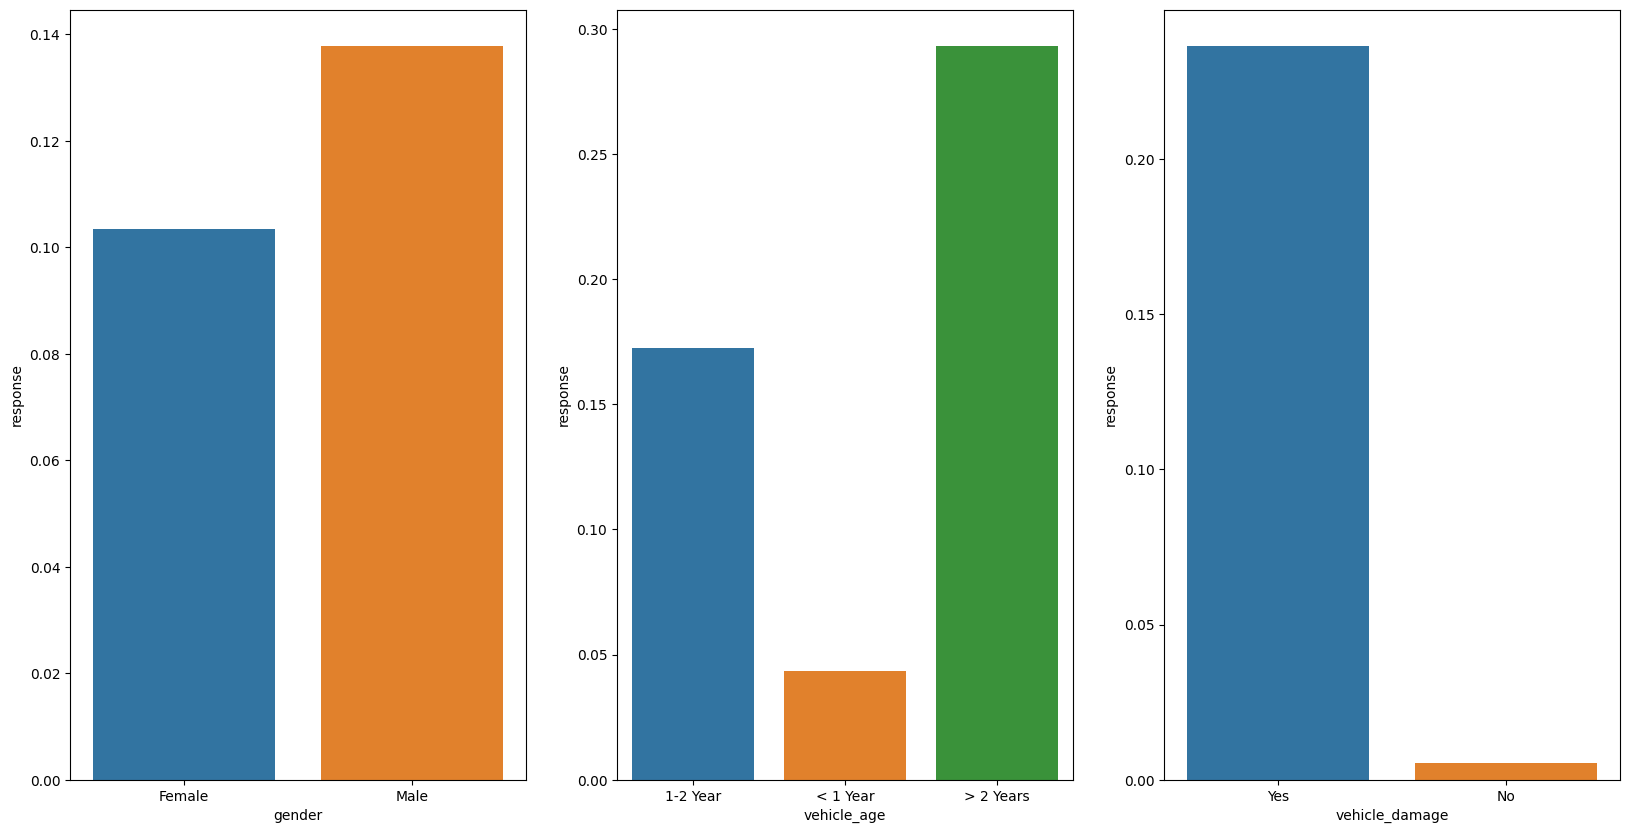

In [21]:

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot(x='gender', y='response', data=df1, errorbar=None)

plt.subplot(1,3,2)
sns.barplot(x='vehicle_age', y='response', data=df1, errorbar=None)

plt.subplot(1,3,3)
sns.barplot(x='vehicle_damage', y='response', data=df1, errorbar=None)


# 2.0 FEATURE ENGINEERING

## 2.1 Hypothesis

1. Pessoas que já possuem um seguro de saúde podem estar mais inclinadas a adquirir um seguro de veículo, pois já têm experiência com seguros.
2. Clientes que possuem um histórico de acidentes de carro podem estar mais interessados em um seguro de veículo.
3. Clientes que possuem um carro mais novo são mais prováveis de adquirirem o seguro.
4. A idade do cliente pode ser um fator importante, com os clientes mais jovens sendo menos propensos a adquirir um seguro de veículo.
5. A localização geográfica dos clientes pode ser um fator importante, com as pessoas que moram em áreas com altos índices de roubos de veículos sendo mais propensas a adquirir um seguro de veículo.
6. O gênero do cliente pode ser um fator, com homens sendo mais propensos a adquirir um seguro de veículo.
7. O preço do seguro de veículo pode ser um fator importante, com clientes mais propensos a adquirir um seguro de veículo se os preços estiverem competitivos.
8. Clientes com CNH são mais propensos a adquirirem o seguro.

## 2.2 Feature Engineering

In [22]:
df2 = df1.copy()

In [23]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,Female,39,1,15.0,0,1-2 Year,Yes,52906.0,55.0,227,1
116248,116249,Male,38,1,11.0,0,1-2 Year,Yes,23038.0,26.0,29,0
255005,255006,Male,22,1,30.0,1,< 1 Year,No,45318.0,152.0,166,0
317474,317475,Female,23,1,41.0,1,< 1 Year,No,29132.0,151.0,277,0
344212,344213,Male,56,1,48.0,0,> 2 Years,Yes,2630.0,154.0,155,0


In [24]:
df2 = rename_categorical(df2)

In [25]:
    df2.sample(15).T

,11084,284240,93089,374550,3723,341340,55921,18923,332043,45585,48163,27814,278434,203647,361022
id,11085,284241,93090,374551,3724,341341,55922,18924,332044,45586,48164,27815,278435,203648,361023
gender,1,0,0,0,0,0,0,1,1,1,0,1,0,1,1
age,53,21,46,21,46,22,38,22,43,21,54,36,64,49,57
driving_license,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
region_code,23.0,47.0,15.0,37.0,8.0,20.0,26.0,3.0,46.0,50.0,35.0,28.0,47.0,46.0,28.0
previously_insured,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
vehicle_age,used,new,used,new,used,new,used,new,used,new,used,used,used,used,used
vehicle_damage,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0
annual_premium,33120.0,2630.0,33464.0,33548.0,23948.0,2630.0,27406.0,2630.0,25790.0,35853.0,43177.0,38705.0,43588.0,18309.0,36949.0
policy_sales_channel,124.0,160.0,86.0,152.0,124.0,152.0,152.0,152.0,157.0,160.0,26.0,26.0,26.0,124.0,124.0


# 3.0 VARIABLE FILTERING

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,0,39,1,15.0,0,used,1,52906.0,55.0,227,1
116248,116249,1,38,1,11.0,0,used,1,23038.0,26.0,29,0
255005,255006,1,22,1,30.0,1,new,0,45318.0,152.0,166,0
317474,317475,0,23,1,41.0,1,new,0,29132.0,151.0,277,0
344212,344213,1,56,1,48.0,0,old,1,2630.0,154.0,155,0


# 4.0 EXPLORATORY DATA ANALYSIS

In [30]:
df4 = df3.copy()

In [31]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,0,39,1,15.0,0,used,1,52906.0,55.0,227,1
116248,116249,1,38,1,11.0,0,used,1,23038.0,26.0,29,0
255005,255006,1,22,1,30.0,1,new,0,45318.0,152.0,166,0
317474,317475,0,23,1,41.0,1,new,0,29132.0,151.0,277,0
344212,344213,1,56,1,48.0,0,old,1,2630.0,154.0,155,0


## 4.1 Unilateral Analysis

### 4.1.1 Numerical Variables

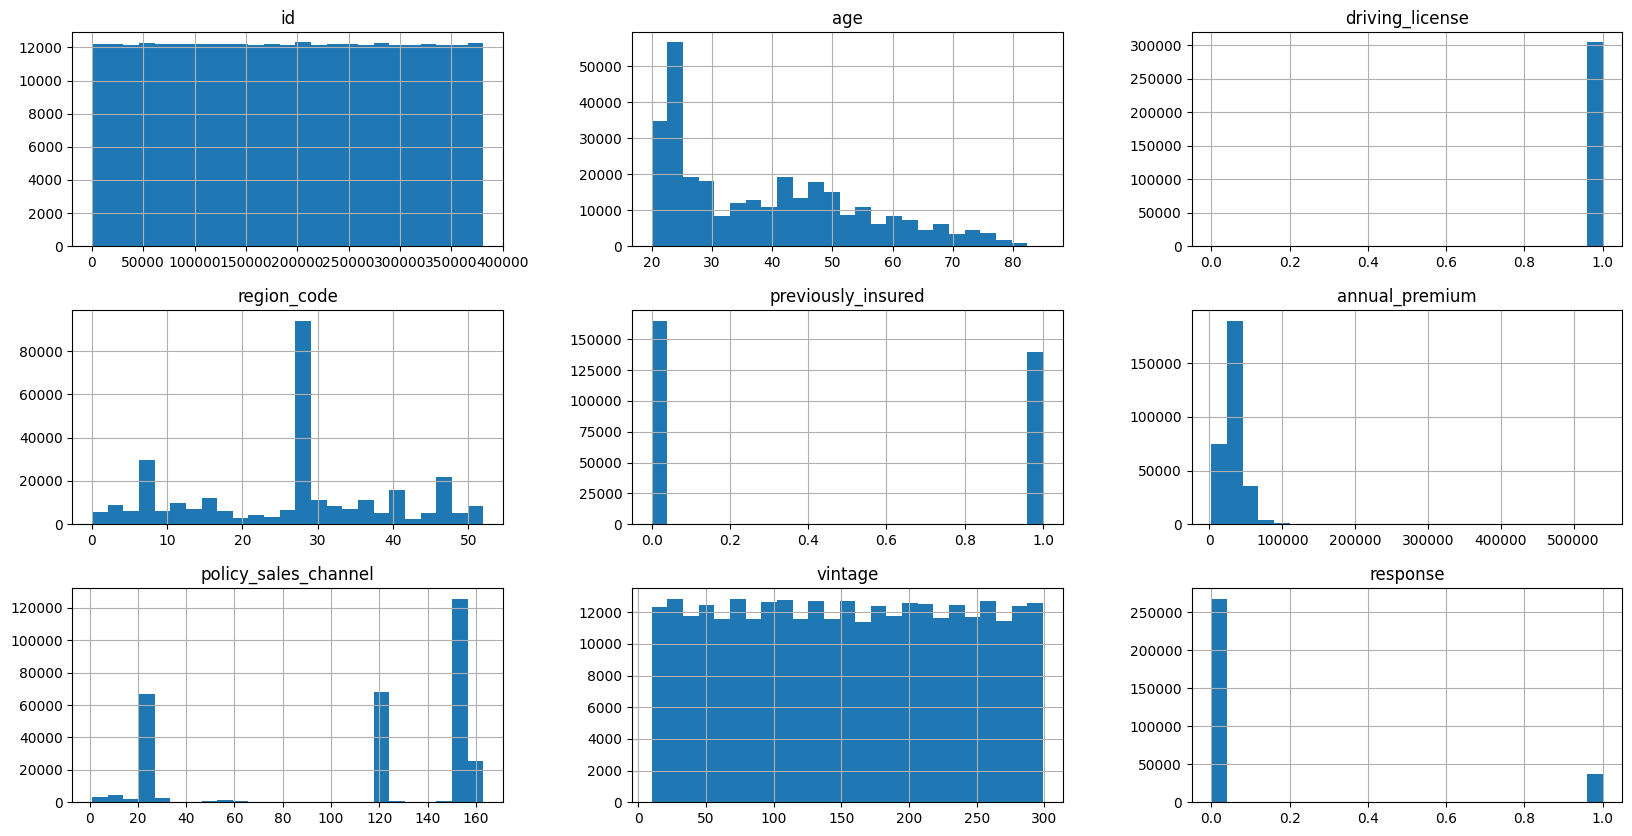

In [32]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
numerical_attributes.hist(ax = ax, bins=25);

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



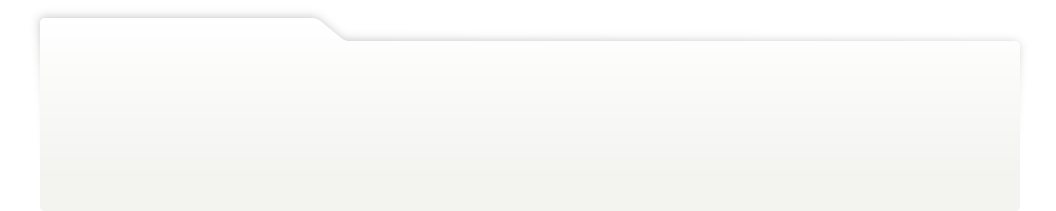
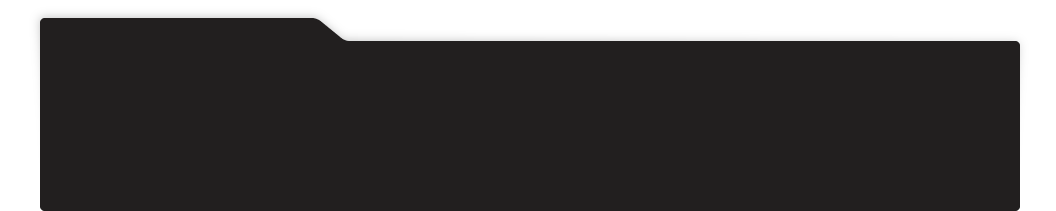
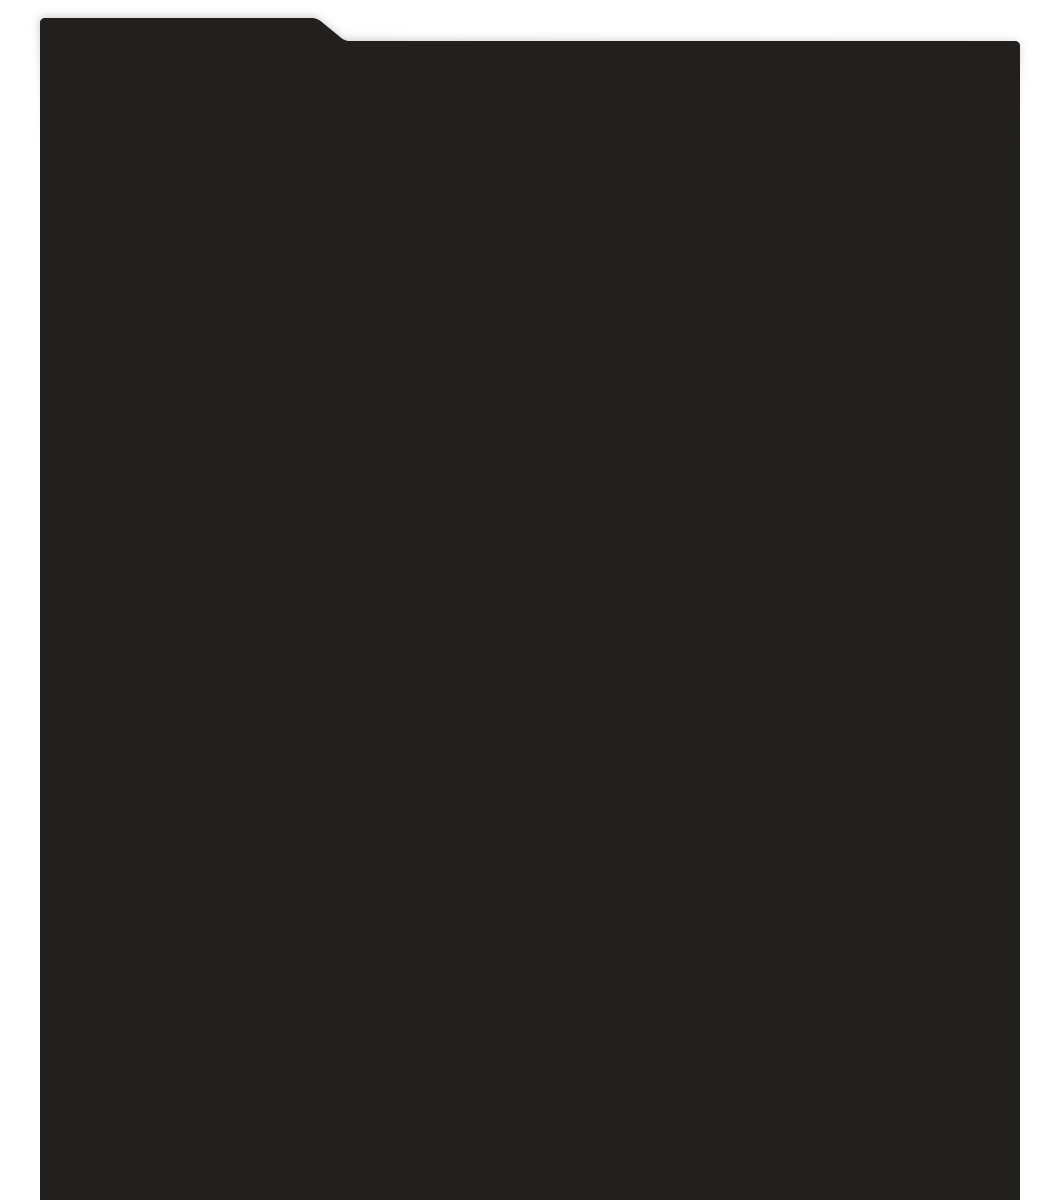
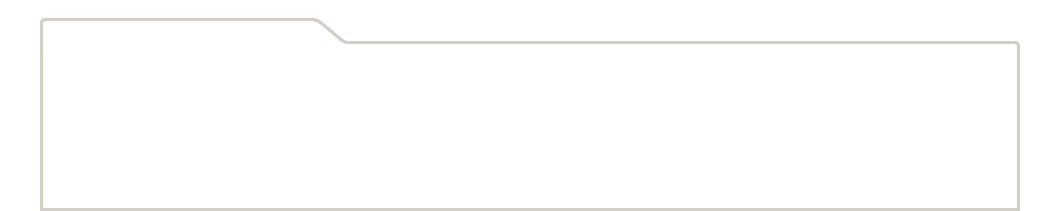
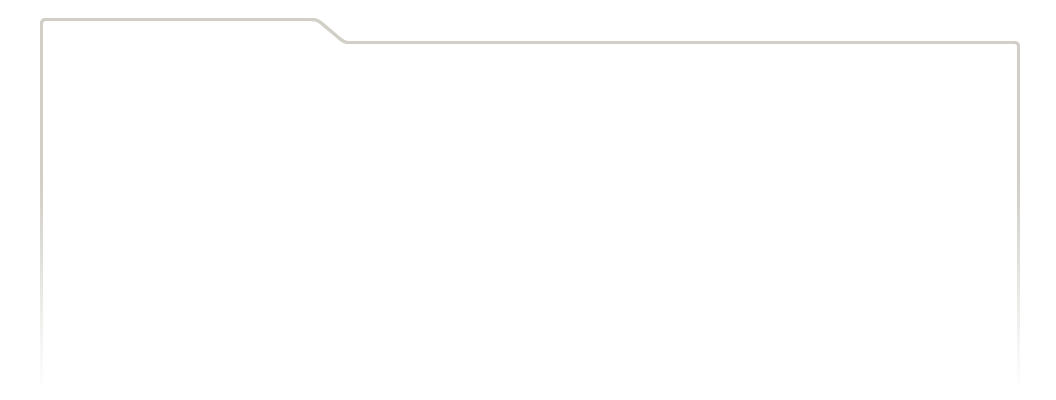
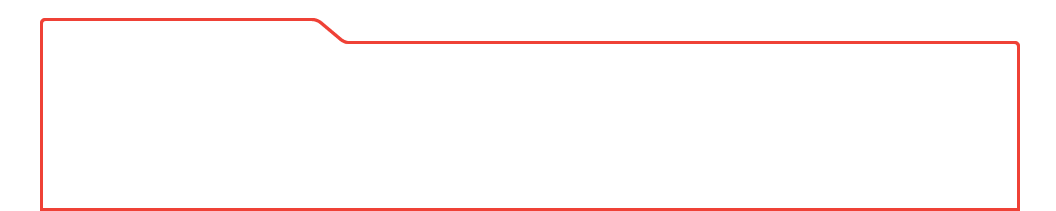
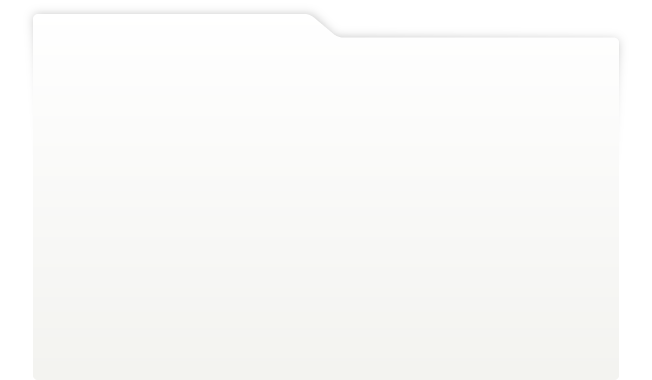
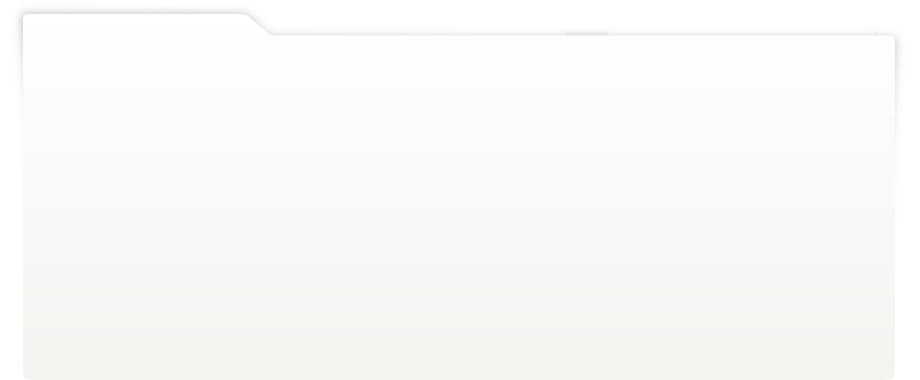
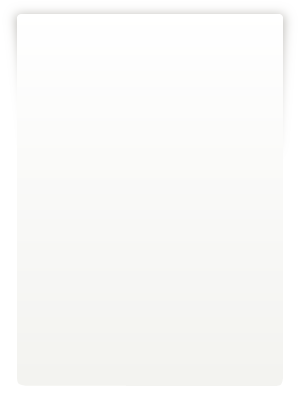
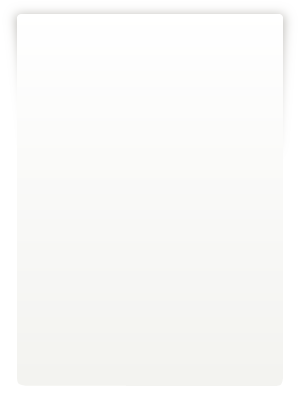
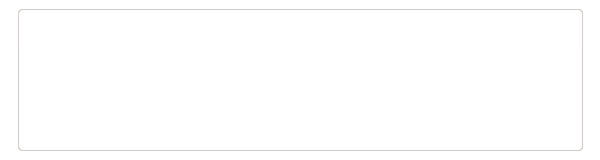
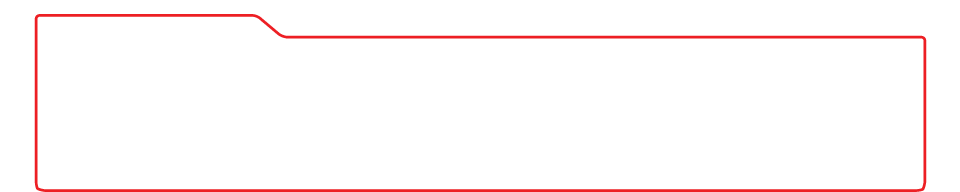
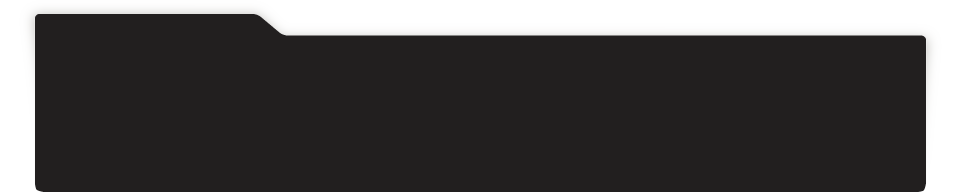
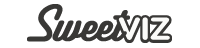
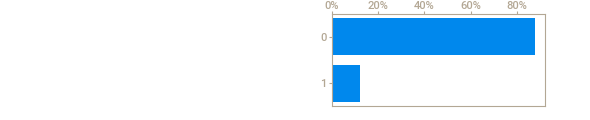
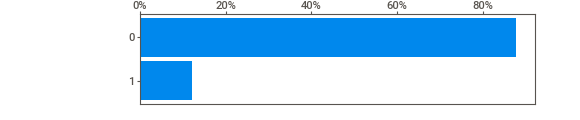
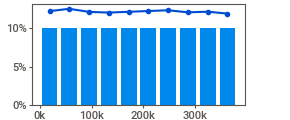
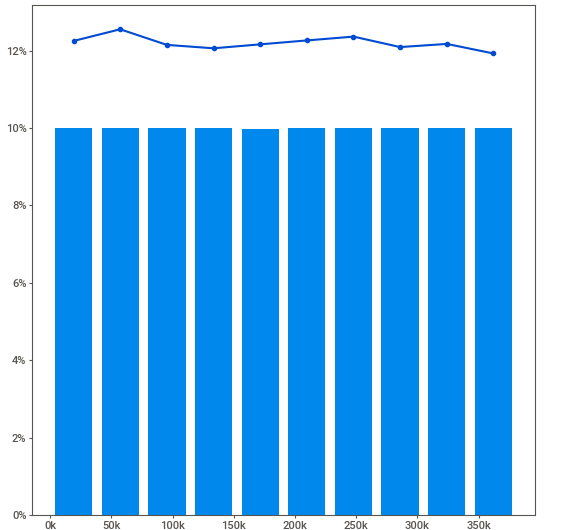
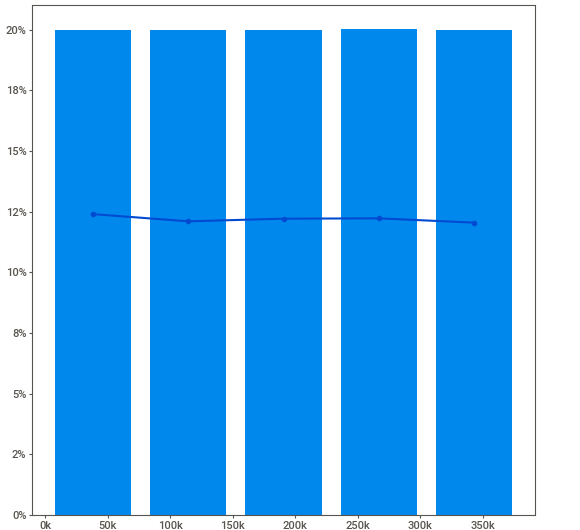
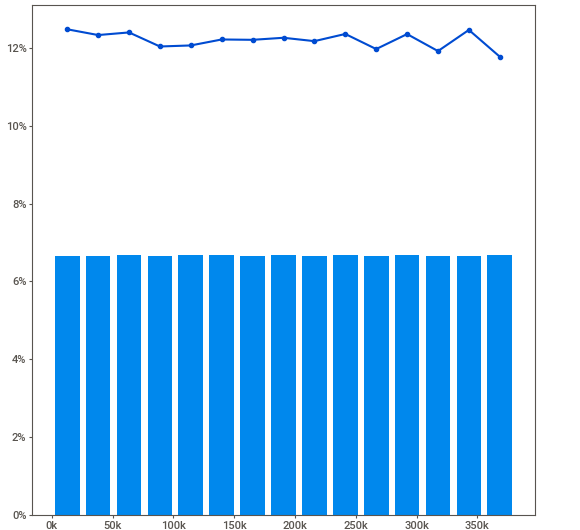
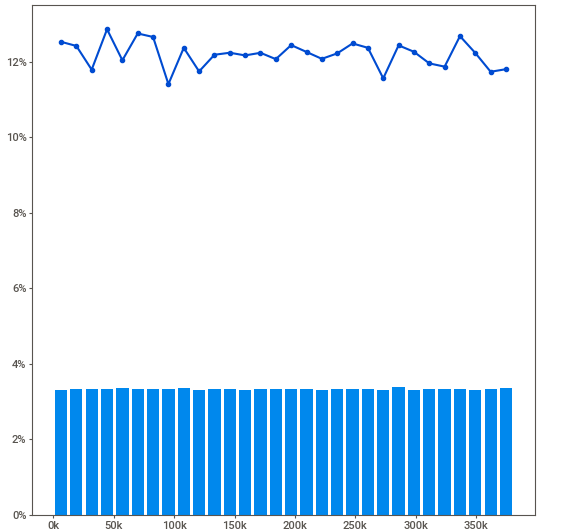
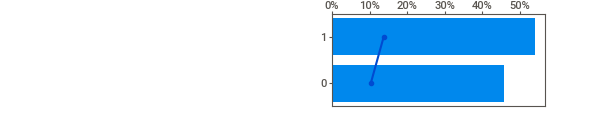
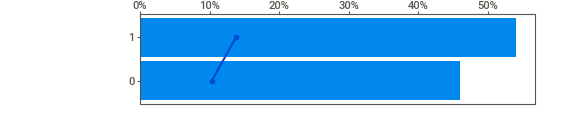
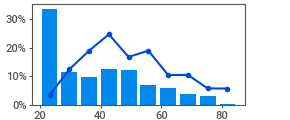
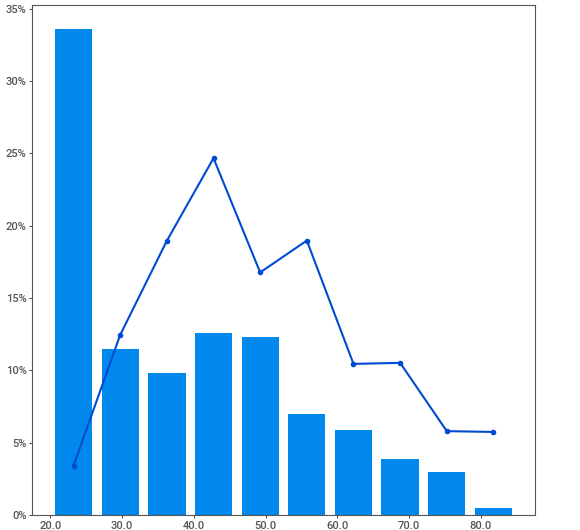
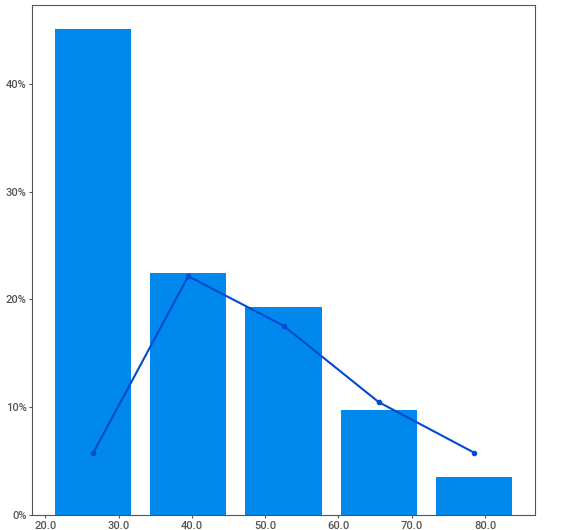
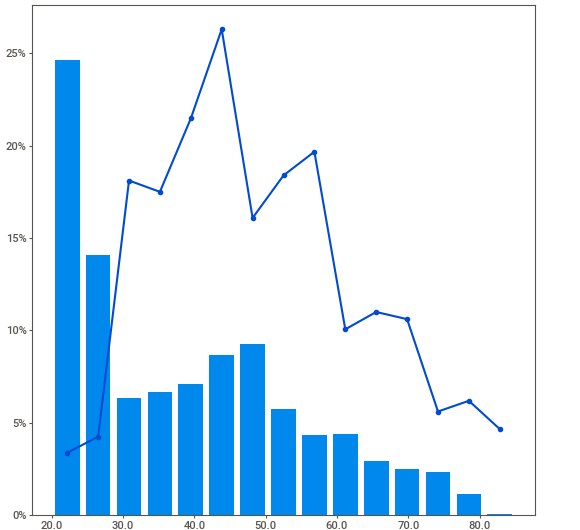
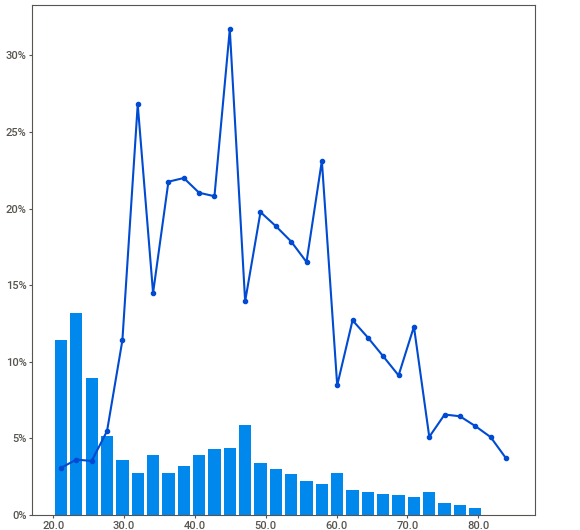
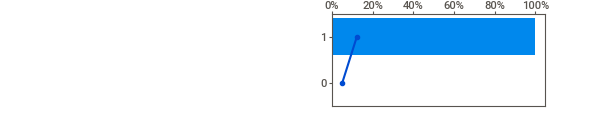
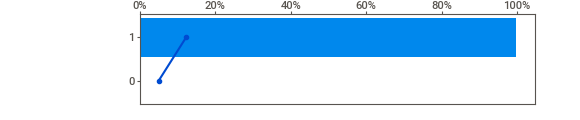
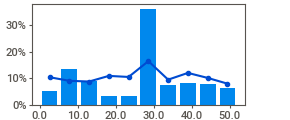
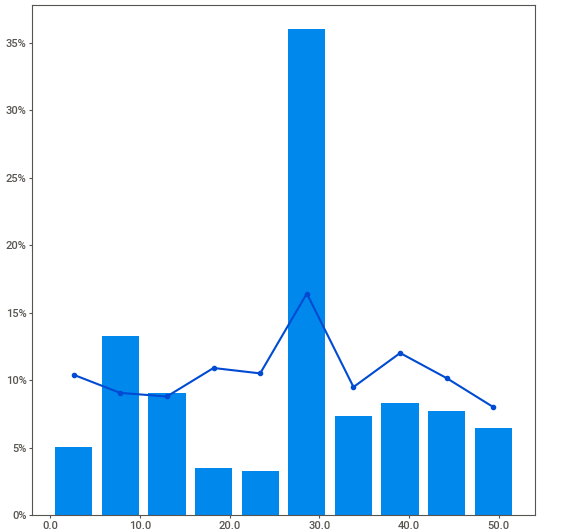
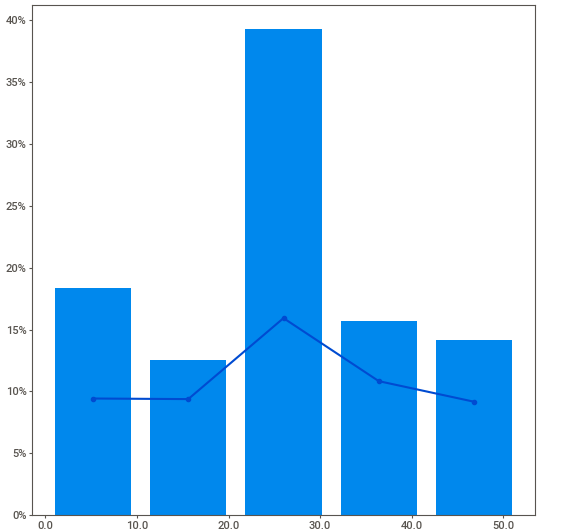
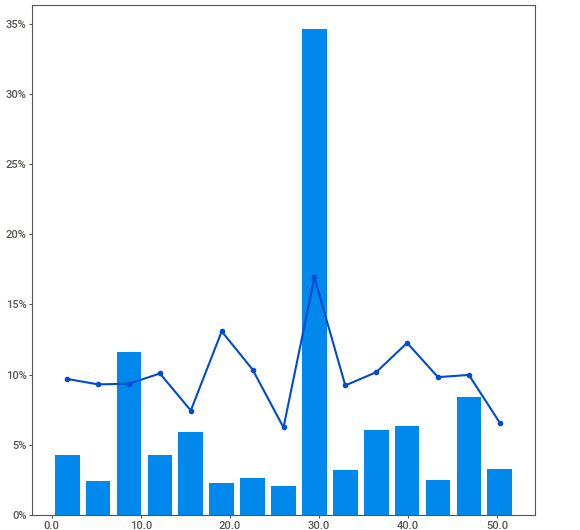
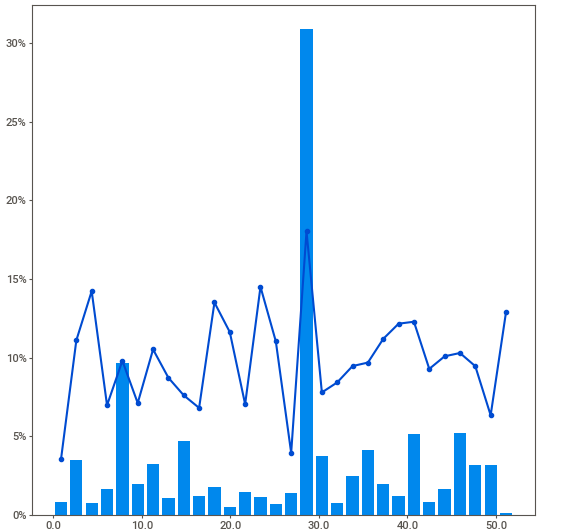
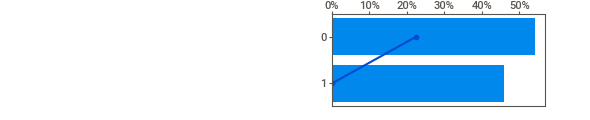
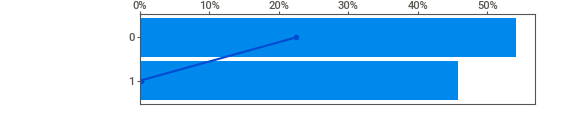
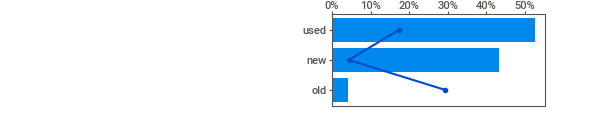
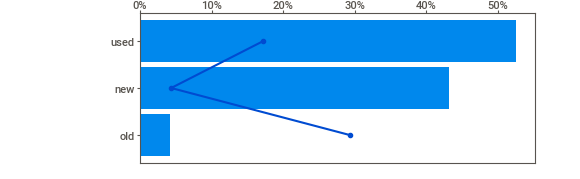
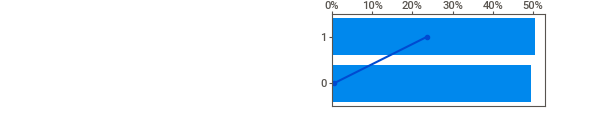
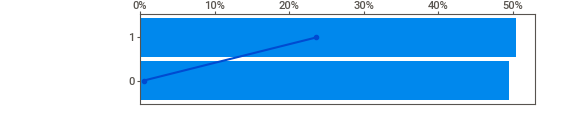
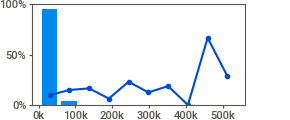
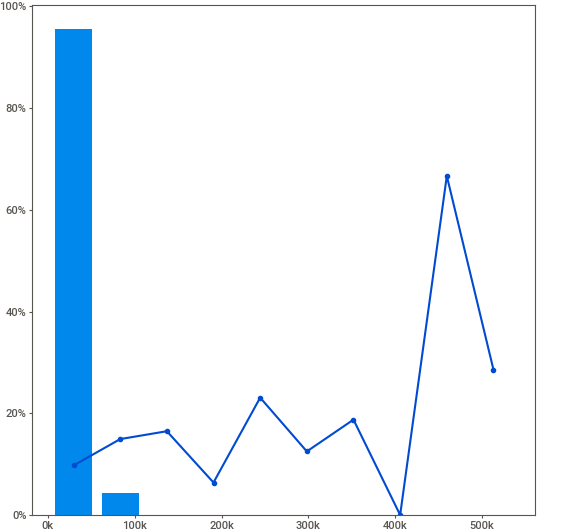
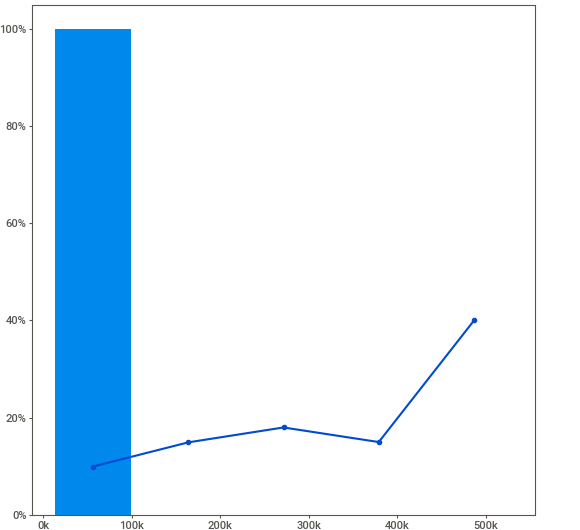
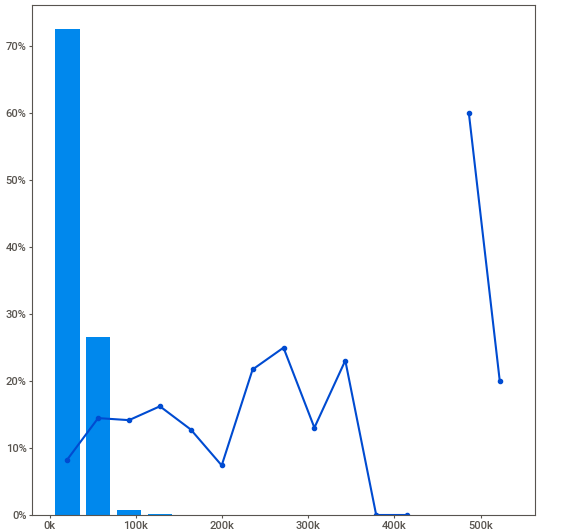
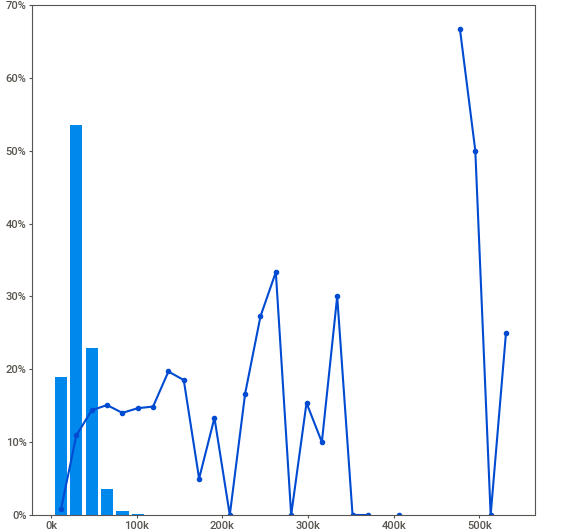
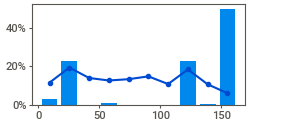
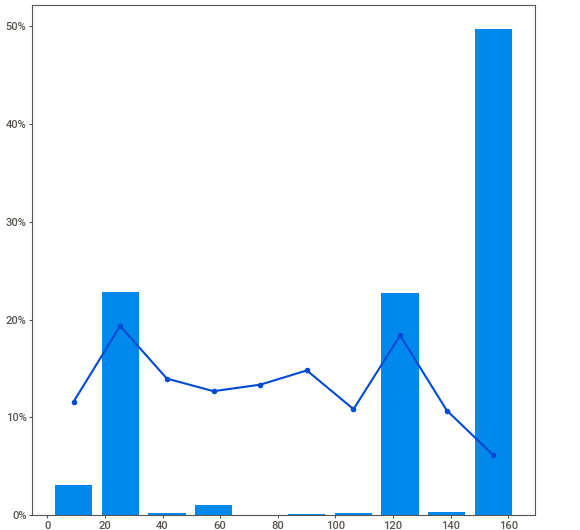
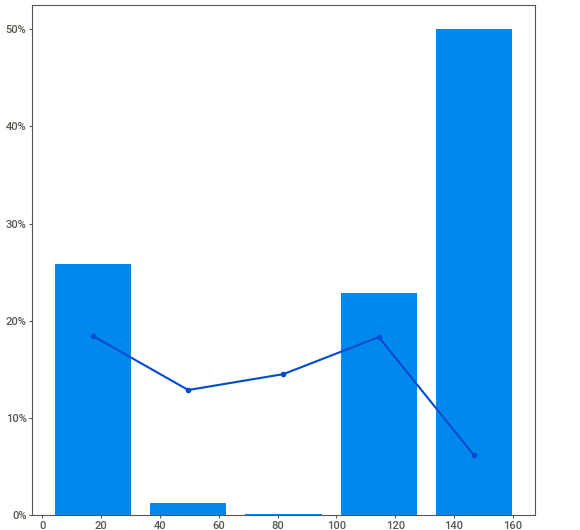
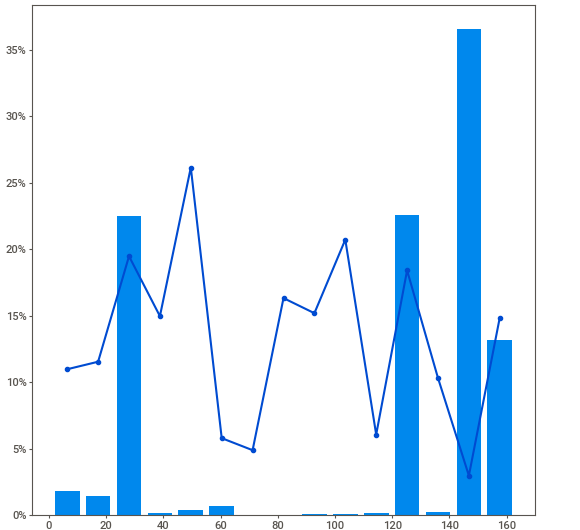
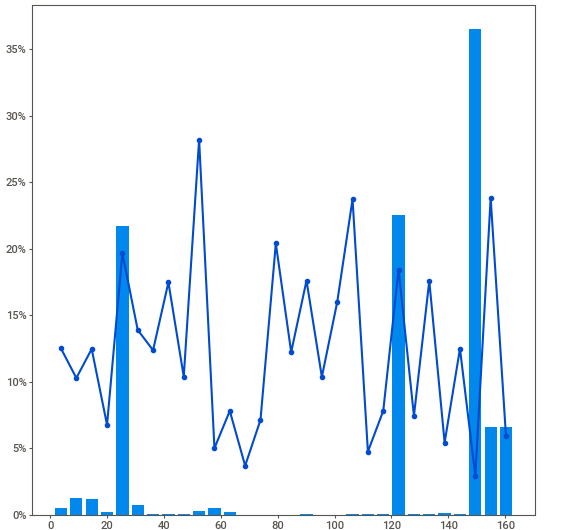
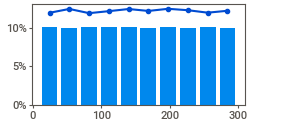
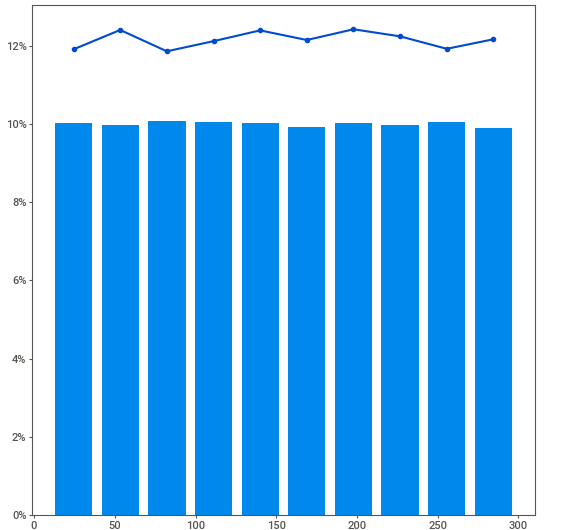
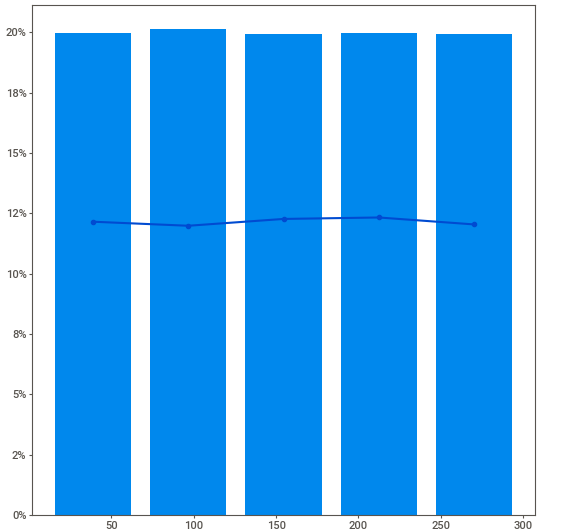
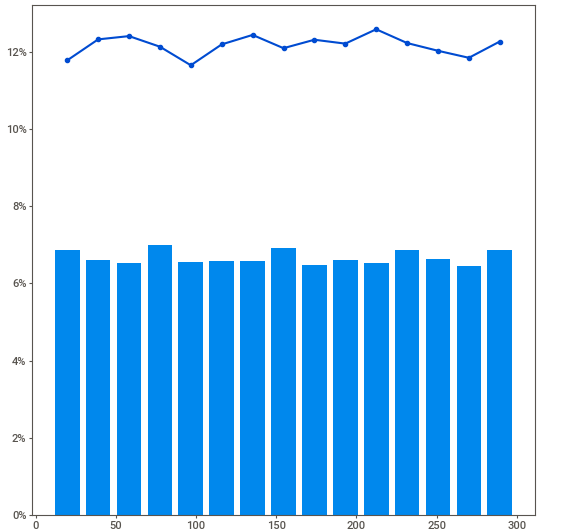
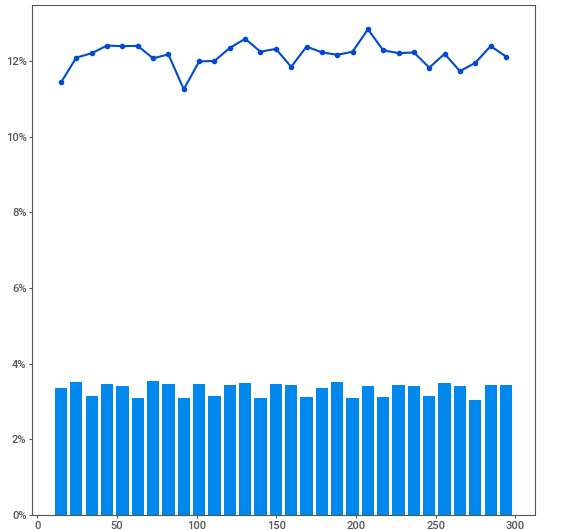
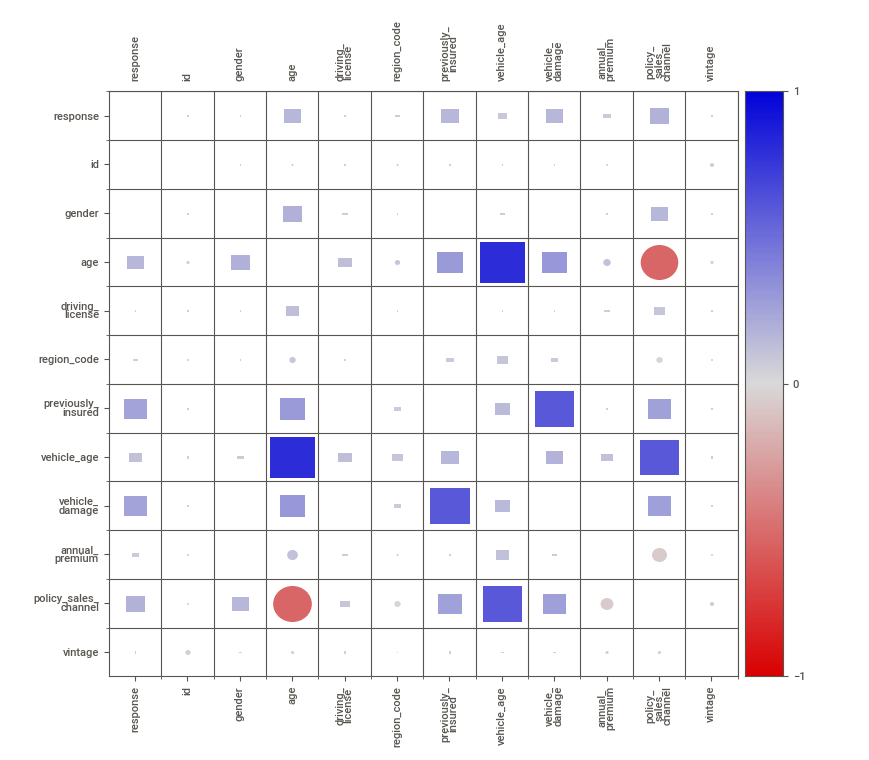
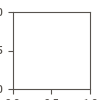

In [33]:
report = sv.analyze(source = df4, target_feat = 'response')

report.show_notebook(w="100%", h="full") # if working in Kaggle

### 4.1.2 Categorical Variables

In [34]:
categorical_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

<Axes: xlabel='vehicle_damage', ylabel='count'>

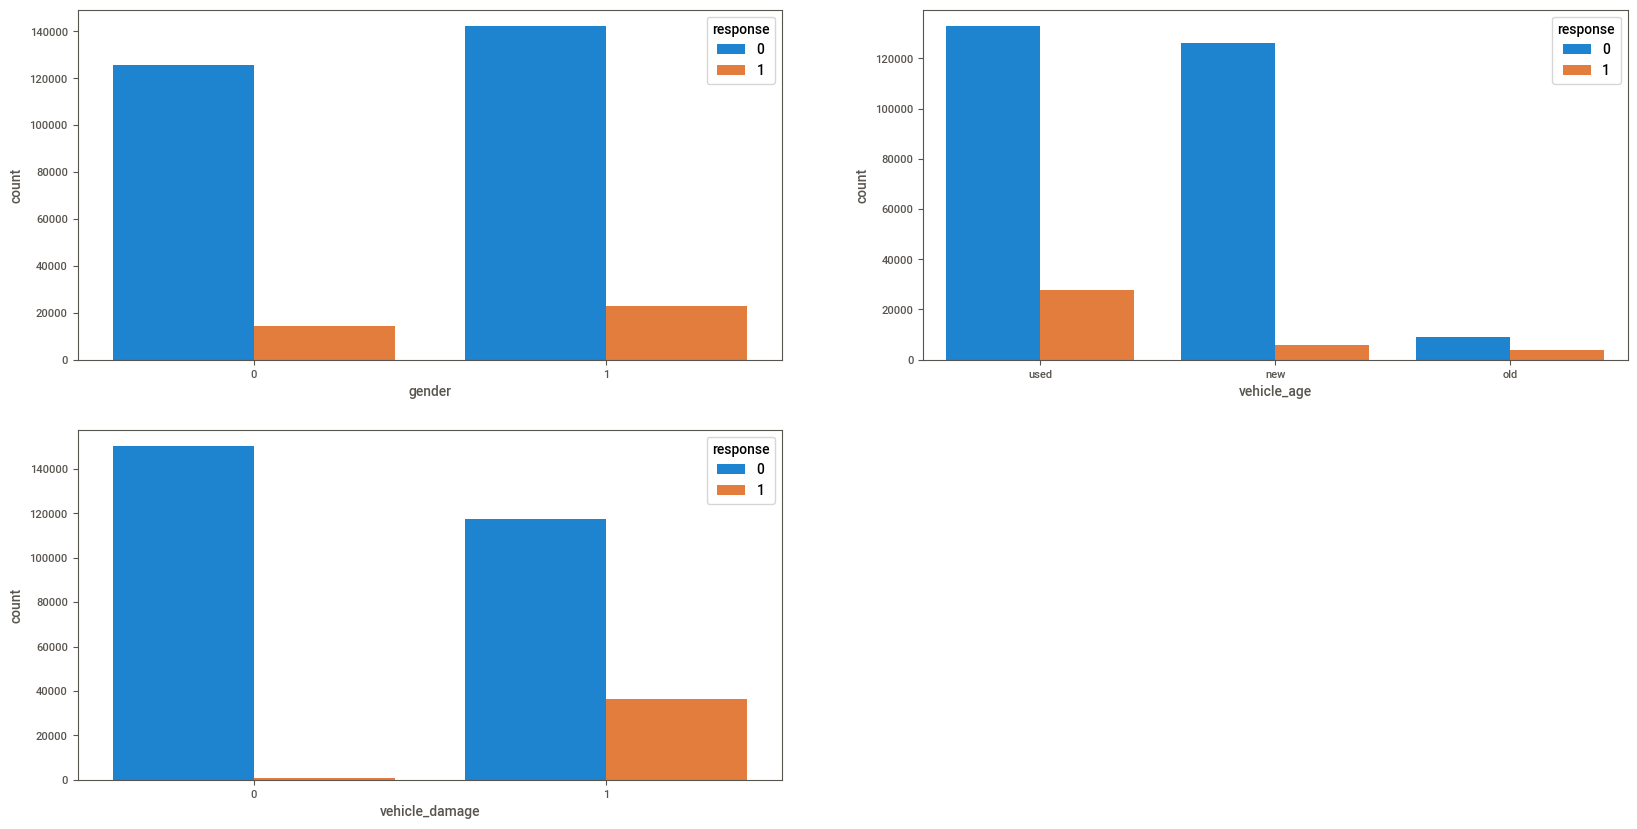

In [35]:
plt.figure(figsize=(20,10))

#gender
plt.subplot(2,2,1)
sns.countplot(data=df4, x='gender', hue='response')

#vehicle_age
plt.subplot(2,2,2)
sns.countplot(data=df4, x='vehicle_age', hue='response')

#vehicle_damage
plt.subplot(2,2,3)
sns.countplot(data=df4, x='vehicle_damage', hue='response')


## 4.2 Bilateral Analysis

### 4.2.1 H1 - Pessoas que já possuem um seguro de saúde podem estar mais inclinadas a adquirir um seguro de veículo, pois já têm experiência com seguros.

<Axes: xlabel='vintage', ylabel='Count'>

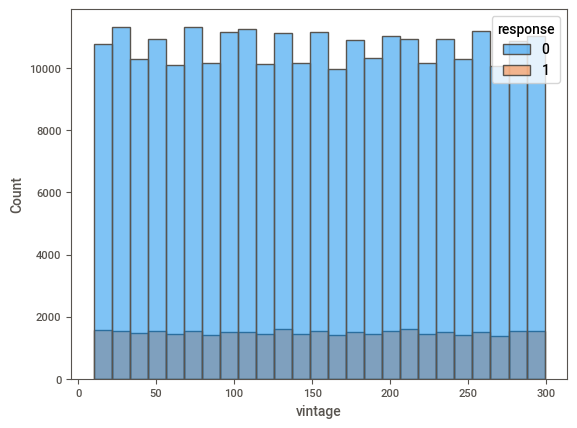

In [36]:
#Vintage
sns.histplot(x='vintage', hue='response', bins=25, data=df4)

 H1 - FALSO. Podemos ver que não há muita diferença nas barras laranjas se o cliente está com pouco dias <50 ou muito dias >250

### 4.2.2 H2 - Clientes que possuem um histórico de acidentes de carro podem estar mais interessados em um seguro de veículo.

<Axes: xlabel='vehicle_damage', ylabel='count'>

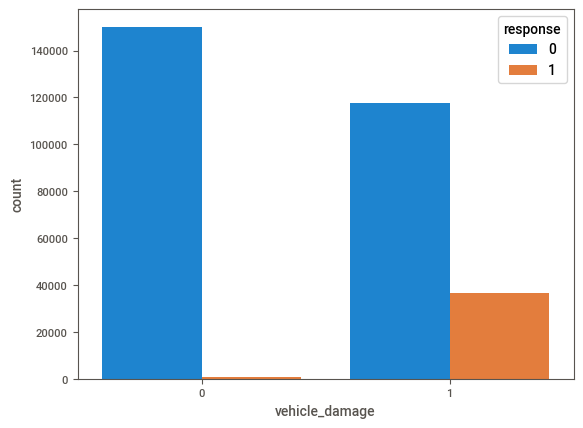

In [37]:
sns.countplot(data=df4, x='vehicle_damage', hue='response')

H2 - VERDADEIRO - Podemos ver que clientes que já tiveram defeito no carro no passado tendem a querer o seguro mais do que os que não tiveram

### 4.2.3 H3 - Clientes que possuem um carro mais novo são mais prováveis de adquirirem o seguro.

<Axes: xlabel='vehicle_age', ylabel='count'>

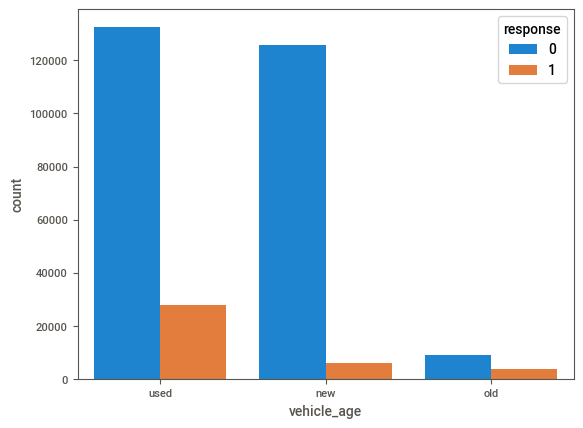

In [38]:
sns.countplot(data=df4, x='vehicle_age', hue='response')

H3 - FALSO - Clientes que possuem carros USADOS (entre 1 e 2 anos) são os que tendem a querer o seguro.

### 4.2.4 H4 - A idade do cliente pode ser um fator importante, com os clientes mais jovens sendo menos propensos a adquirir um seguro de veículo.

Text(0.5, 1.0, 'Idade Apenas dos que querem o seguro')

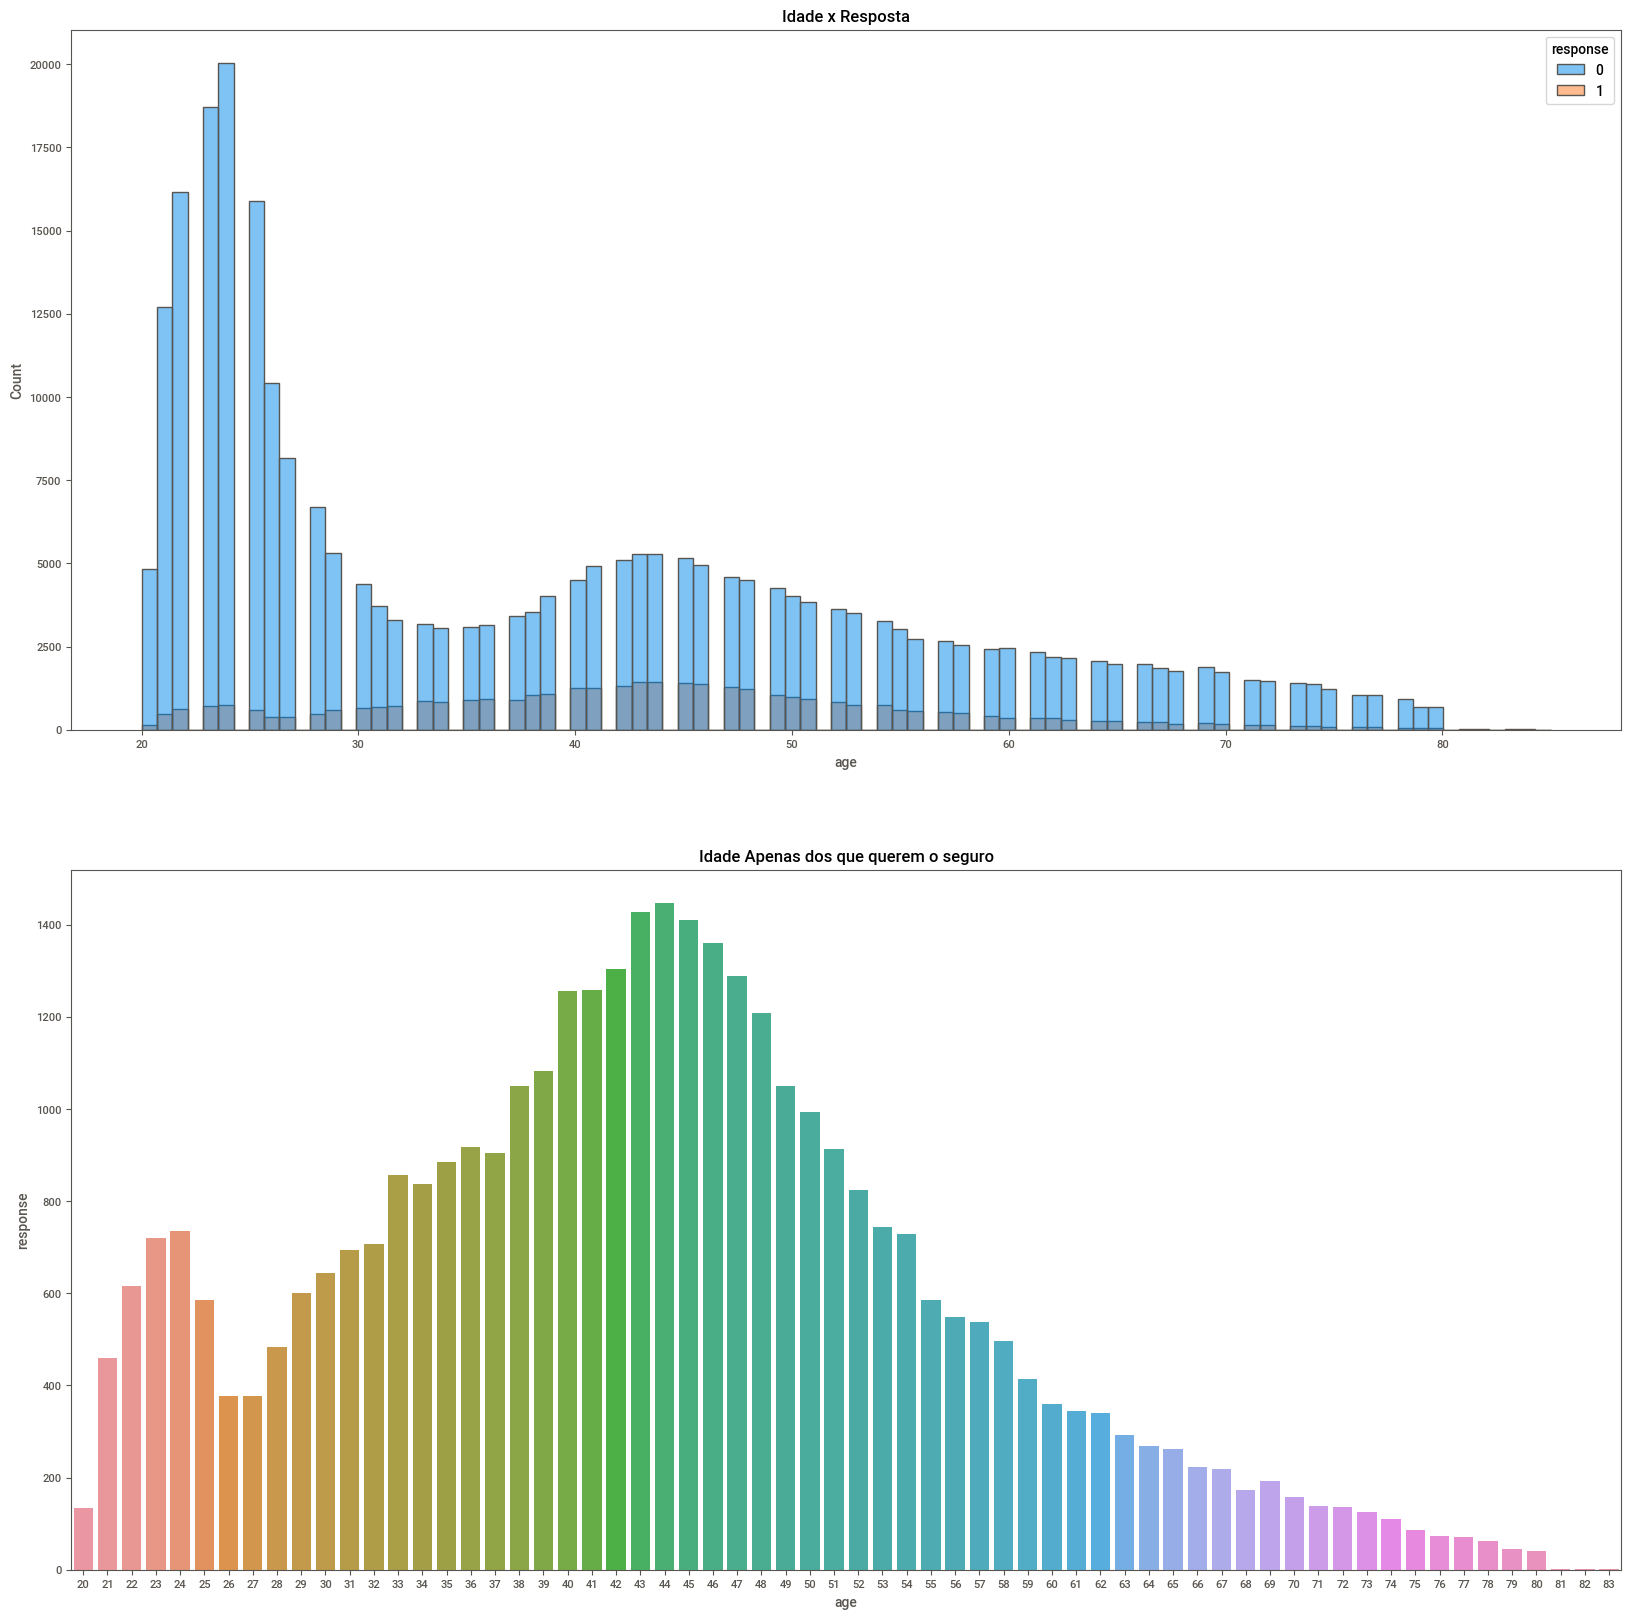

In [39]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.histplot(x='age', hue='response', data=df4)
plt.title("Idade x Resposta")

plt.subplot(2,1,2)
aux = df4.loc[df4['response'] == 1,['response','age']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux)
plt.title("Idade Apenas dos que querem o seguro")

H4 - VERDADEIRO - Os clientes entre a faixa de 40 e 50 são os mais propensos a adquirir o seguro

### 4.2.5 H5 - A localização geográfica dos clientes pode ser um fator importante, com as pessoas que moram em áreas com altos índices de roubos de veículos sendo mais propensas a adquirir um seguro de veículo.

<Axes: xlabel='region_code', ylabel='response'>

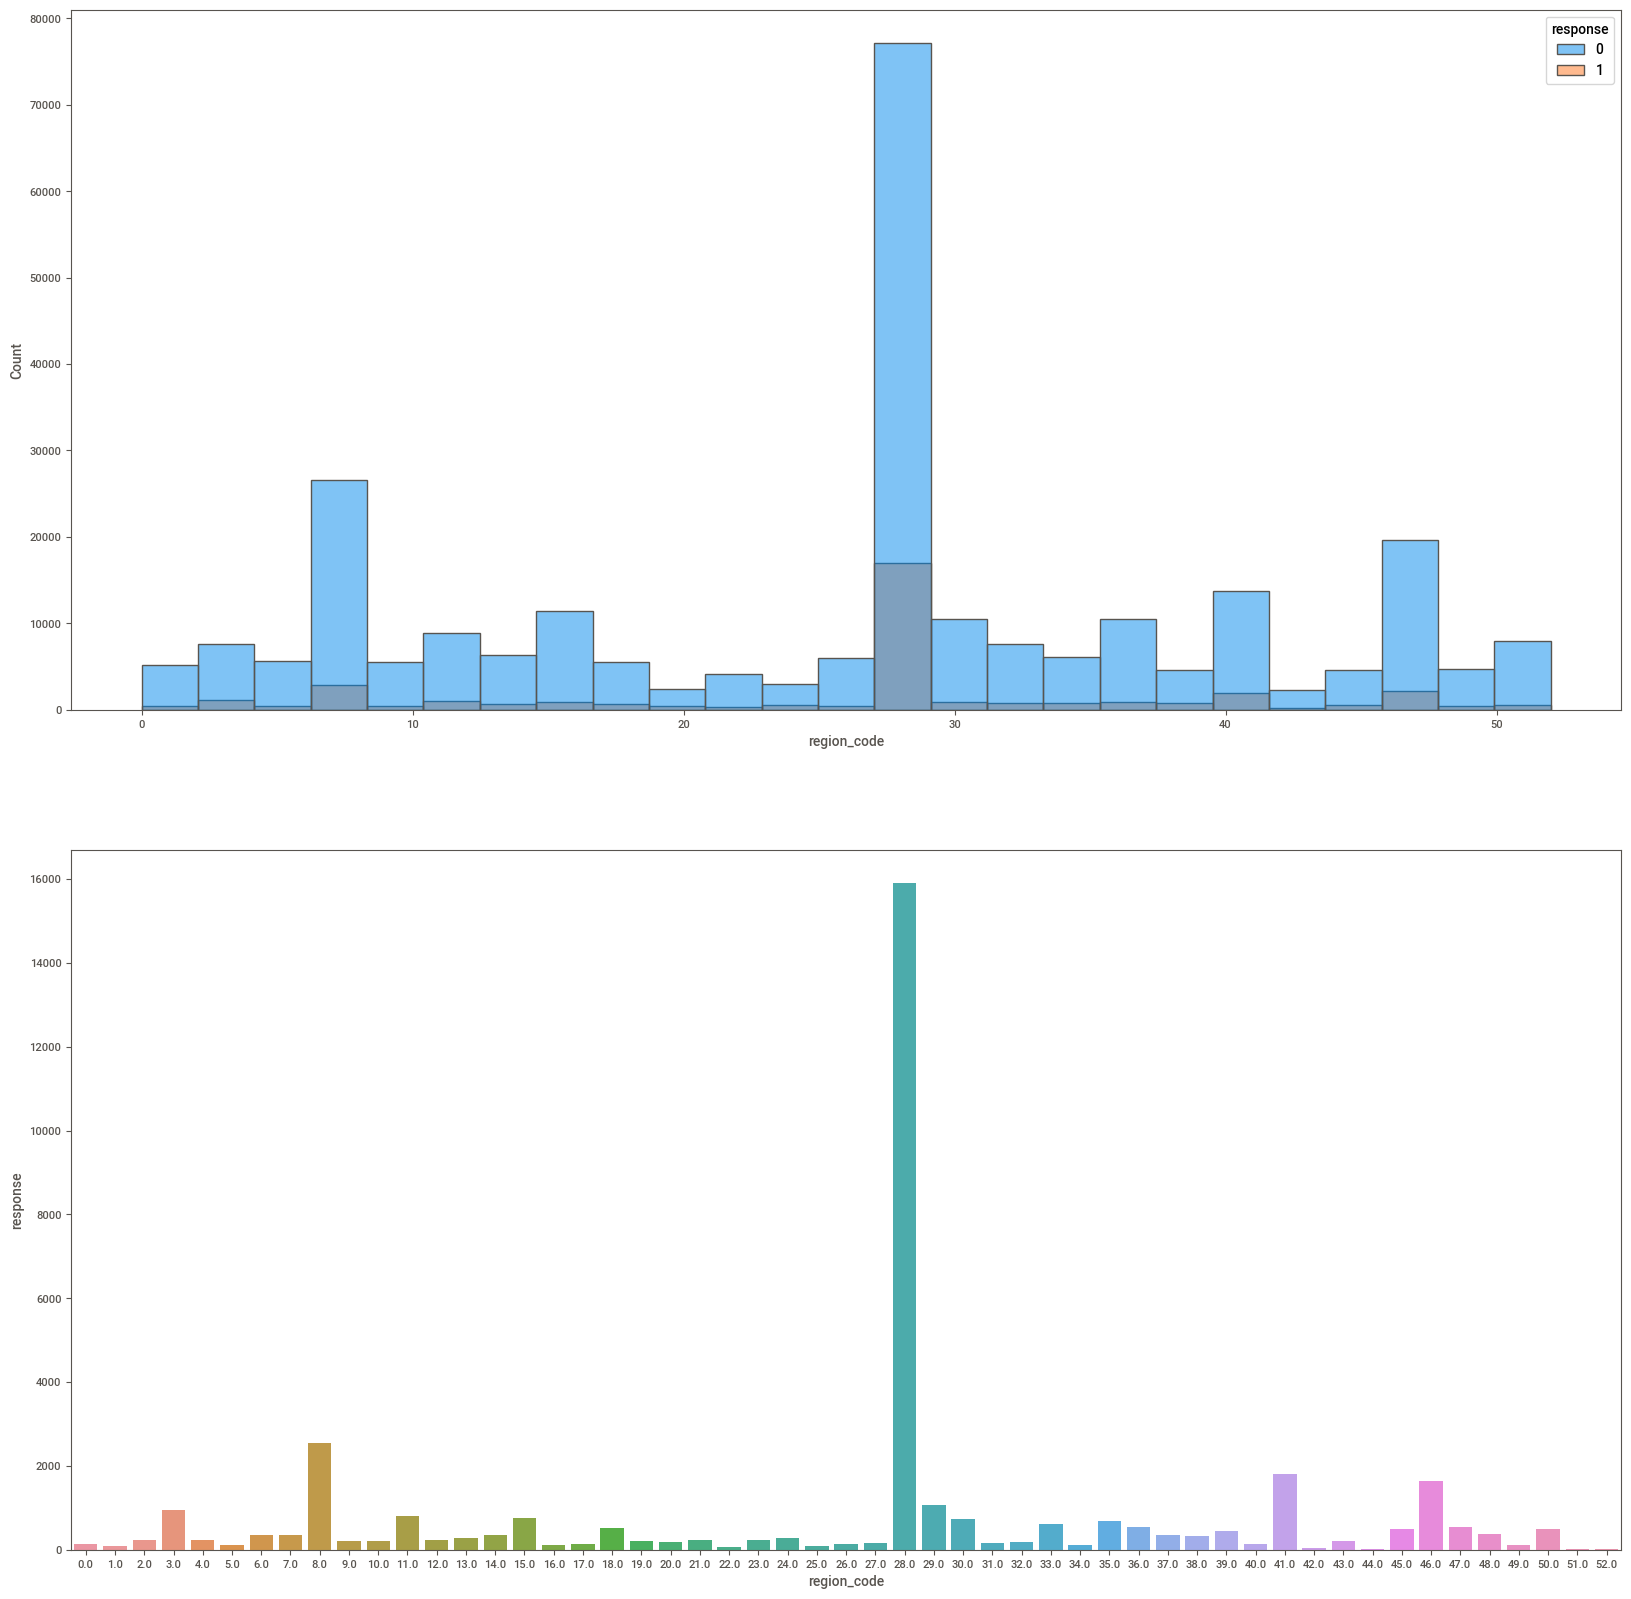

In [40]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.histplot(x='region_code', hue='response', data=df4, bins=25)

plt.subplot(2,1,2)
aux = df4.loc[df4['response'] == 1,['response','region_code']].groupby('region_code').sum().reset_index()
sns.barplot(x='region_code', y='response', data=aux)

VERDADEIRO - Podemos ver que na região 028 temos muito mais clientes interessados em adquirir o seguro.

### 4.2.6 H6 - O gênero do cliente pode ser um fator, com homens sendo mais propensos a adquirir um seguro de veículo.

<Axes: xlabel='gender', ylabel='Count'>

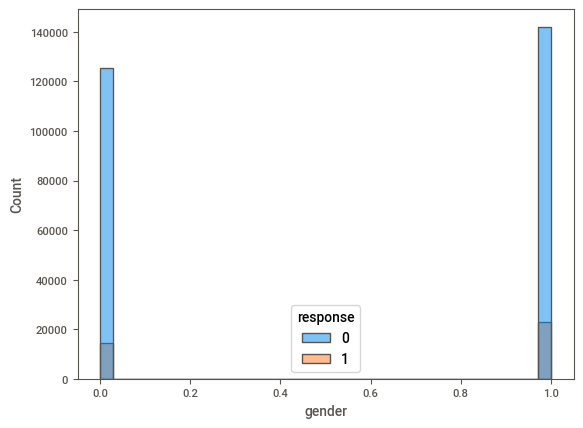

In [41]:
sns.histplot(x='gender', hue='response', data=df4)

VERDADEIRO - Podemos ver pelas barras laranjas que, dos que têm interesse no seguro, a maioria são homens.

### 4.2.7 H7 - O preço do seguro de veículo pode ser um fator importante, com clientes mais propensos a adquirir um seguro de veículo se os preços estiverem competitivos.

<Axes: xlabel='annual_premium', ylabel='Count'>

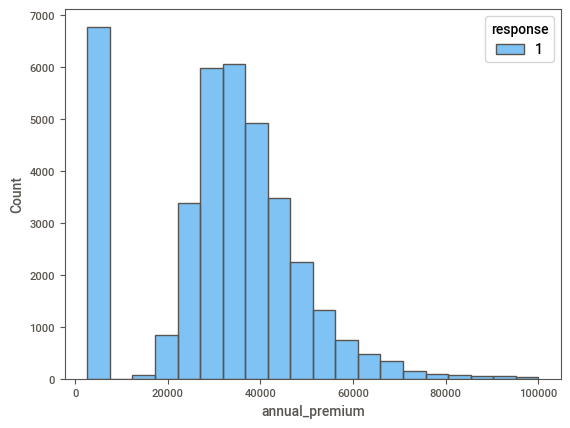

In [42]:
aux1 = df4.loc[(df4['response'] == 1) & (df4['annual_premium'] < 100000),['annual_premium','response']]
sns.histplot(x='annual_premium', hue='response', data=aux1, bins=20)

VERDADEIRO - A maioria dos clientes que gostariam de adquirir o seguro seria no valor de 2630. Depois o pico aparece em torno dos 40.000. Provavelmente esse seguro de 2630 seja o mais barato com algumas vantagens e depois o de 40.000 ofereça vantagens mais robustas.

### 4.2.8 H8 - Clientes com CNH são mais propensos a adquirirem o seguro.

<Axes: xlabel='driving_license', ylabel='Count'>

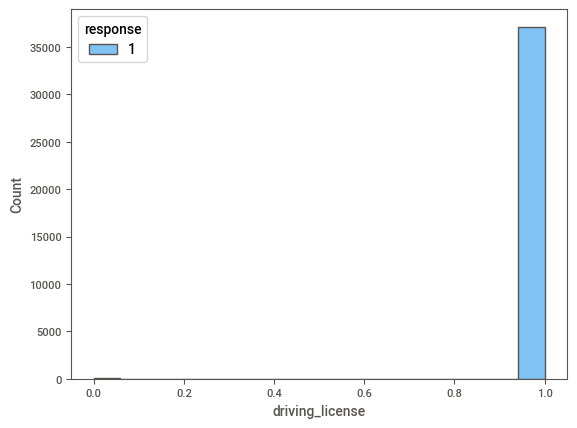

In [43]:
aux1 = df4.loc[df4['response'] == 1,['driving_license','response']]
sns.histplot(x='driving_license', hue='response', data=aux1)

VERDADEIRO - A maioria dos clientes que querem o seguro possuem CNH.

### 4.2.9 - H9 - Pessoas que já tinham seguros anteriormente tendem a querer o seguro, pois já têm experiência.

<Axes: xlabel='previously_insured', ylabel='Count'>

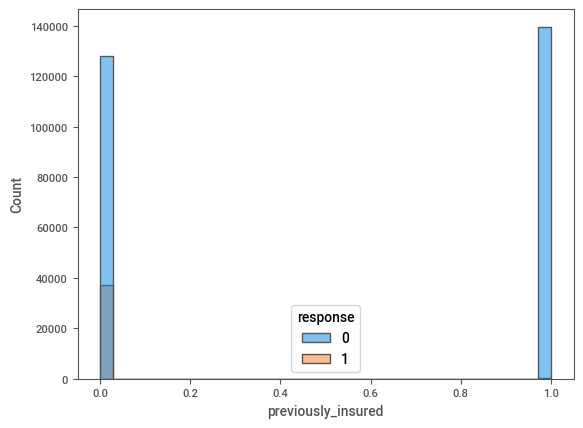

In [44]:
sns.histplot(x='previously_insured', hue='response', data=df4)

FALSO - Praticamente todas as pessoas que já tinham seguro anteriormente não querem o novo seguro.

### 4.2.10 - H10 - Pessoas que são notificadas por algum meio específico(ex: telefone) podem tender a querer o seguro

<Axes: xlabel='policy_sales_channel', ylabel='Count'>

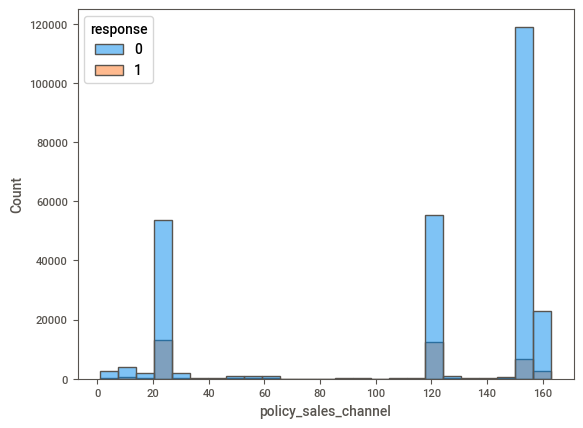

In [45]:
sns.histplot(x='policy_sales_channel', hue='response', data=df4, bins=25)

VERDADEIRO - Existem forma de contato com o cliente que facilitam eles a adquirirem o seguro.

## 4.3 Multilateral Analysis

<Axes: >

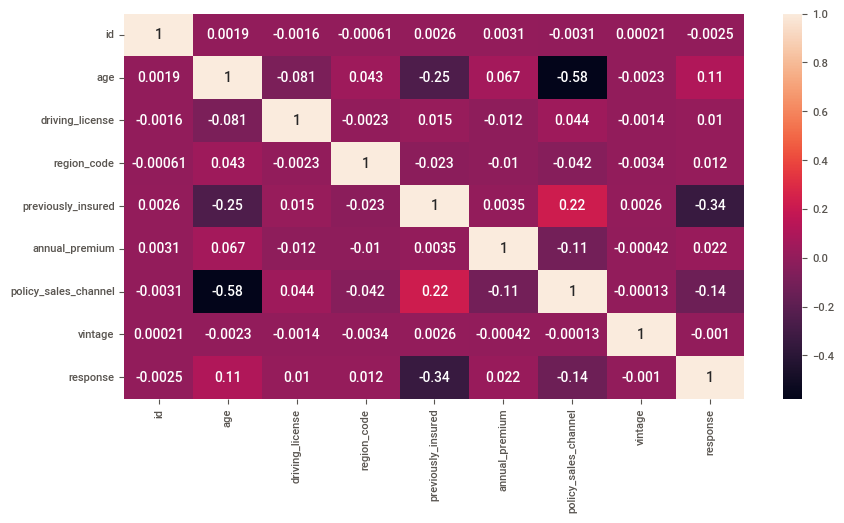

In [46]:
#Correlation Numerical Variables
plt.figure(figsize=(10,5))
sns.heatmap(numerical_attributes.corr(method='pearson'), annot=True)

In [47]:
a = categorical_attributes

<Axes: >

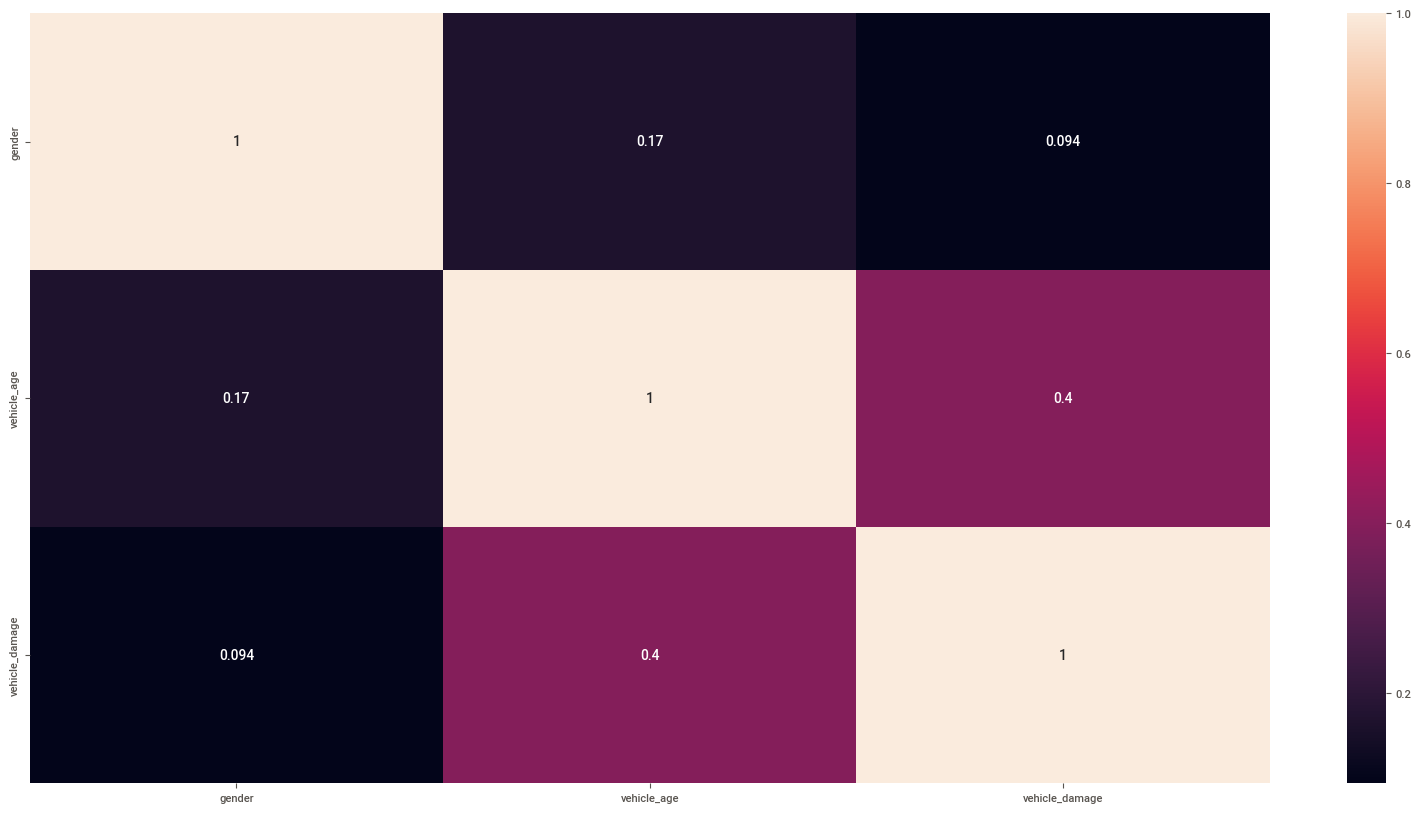

In [48]:
#Correlation Categorical Variables
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a3 = cramer_v( a['gender'], a['vehicle_damage'] )

a4 = cramer_v( a['vehicle_age'], a['gender'] )
a5 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a6 = cramer_v( a['vehicle_age'], a['vehicle_damage'] )

a7 = cramer_v( a['vehicle_damage'], a['gender'] )
a8 = cramer_v( a['vehicle_damage'], a['vehicle_age'] )
a9 = cramer_v( a['vehicle_damage'], a['vehicle_damage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3], 
               'vehicle_age': [a4, a5, a6],
               'vehicle_damage': [a7, a8, a9]  })
d = d.set_index( d.columns )
plt.figure(figsize=(20,10))
sns.heatmap( d, annot=True )

# 5.0 DATA PREPARATION

In [49]:
df5 = df4.copy()

In [50]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,0,39,1,15.0,0,used,1,52906.0,55.0,227,1
116248,116249,1,38,1,11.0,0,used,1,23038.0,26.0,29,0
255005,255006,1,22,1,30.0,1,new,0,45318.0,152.0,166,0
317474,317475,0,23,1,41.0,1,new,0,29132.0,151.0,277,0
344212,344213,1,56,1,48.0,0,old,1,2630.0,154.0,155,0


## 5.1 Encoding

In [51]:
df5 = data_encoding(df5)

## 5.2 Rescalling

In [52]:
df5 = data_rescalling(df5)

## 5.4 Split Dataframe into Training and Validation

In [54]:
X = df5.drop('response', axis=1)
y = df5['response']

X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=42)

df5 = pd.concat([X_train, y_train],axis=1)

In [55]:
#keep ID for precision K
x_validation = X_val
x_validation['response'] = y_val

# 6.0 FEATURE SELECTION

In [56]:
df6 = df5.copy()

In [57]:
df6.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
217927,217928,0,0.276923,1,0.019397,1,1,0,0.070032,0.353472,0.224913,0
54207,54208,1,0.015385,1,0.052085,1,0,0,-0.083025,0.056874,0.391003,0
18364,18365,1,0.707692,1,0.279631,0,1,1,1.547893,0.015901,0.041522,0
195540,195541,0,0.323077,1,0.279631,1,1,0,2.269665,0.209638,0.865052,0
30463,30464,1,0.461538,1,0.034833,0,1,1,0.501749,0.209638,0.730104,0


## 6.1 Boruta

In [58]:
#rf = RandomForestRegressor(n_jobs=-1)

In [59]:
#X = df6.drop('response', axis=1)
#y = df6['response']

#X_train_n, X_test_n, y_train_n, y_test_n = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
#X_train_nn = X_train_n.values
#y_train_nn = y_train_n.ravel()

In [61]:
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_nn, y_train_nn)

In [62]:
#cols_boruta = boruta.support_.tolist()

## 6.2 ExtraTree

In [63]:
# #model
# forest = ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# #data preparation
# x_train_n = X_train.drop(['id'], axis=1)
# y_train_n = y_train.values
# forest.fit(x_train_n, y_train_n)

In [64]:
# importances = forest.feature_importances_
# features = {}

# for i in range(len(x_train_n.columns)):
#     features[x_train_n.columns[i]] = importances[i]
    
# features = pd.DataFrame(features, index=[0])    
# features = features.melt(var_name='Features', value_name='Ranking')
# features.sort_values(ascending=False, by='Ranking')

## 6.3 RandomForest

In [65]:
# #model
# forest = RandomForestClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# #data preparation
# x_train_n = X_train.drop(['id'], axis=1)
# y_train_n = y_train.values
# forest.fit(x_train_n, y_train_n)

In [66]:
# importances = forest.feature_importances_
# features = {}

# for i in range(len(x_train_n.columns)):
#     features[x_train_n.columns[i]] = importances[i]
    
# features = pd.DataFrame(features, index=[0])    
# features = features.melt(var_name='Features', value_name='Ranking')
# features.sort_values(ascending=False, by='Ranking')

In [67]:
cols_selected = {'vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured','vehicle_age','gender'}

# 7.0 Machine Learning

In [68]:
df7 = df6.copy()

In [69]:
df7.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
217927,217928,0,0.276923,1,0.019397,1,1,0,0.070032,0.353472,0.224913,0
54207,54208,1,0.015385,1,0.052085,1,0,0,-0.083025,0.056874,0.391003,0
18364,18365,1,0.707692,1,0.279631,0,1,1,1.547893,0.015901,0.041522,0
195540,195541,0,0.323077,1,0.279631,1,1,0,2.269665,0.209638,0.865052,0
30463,30464,1,0.461538,1,0.034833,0,1,1,0.501749,0.209638,0.730104,0


In [70]:
X_train = X_train.loc[:,cols_selected]
X_val = X_val.loc[:,cols_selected]

## Compare Models

In [71]:
model_list = [  DummyClassifier(),
                LogisticRegression(),
                DecisionTreeClassifier(),
                KNeighborsClassifier(),
                GaussianNB(),
                RandomForestClassifier(),
                XGBClassifier(),
                lgb.LGBMClassifier()]
    

In [72]:
for model in model_list:
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_val)
    print(f"{model} Acurácia Top K: {mt.top_k_accuracy_score(y_val, yhat[:,1], k=1):.3f}%")

DummyClassifier() Acurácia Top K: 0.877%
LogisticRegression() Acurácia Top K: 0.877%
DecisionTreeClassifier() Acurácia Top K: 0.822%


KeyboardInterrupt: 

## 7.1 Dummy Classifier

In [ ]:
model_dummy = DummyClassifier()

model_dummy.fit(X_train, y_train)

yhat_dummy = model_dummy.predict_proba(X_val)

In [ ]:
plt.figure(figsize=(20,10))

skplt.metrics.plot_cumulative_gain(y_val, yhat_dummy)

skplt.metrics.plot_lift_curve(y_val, yhat_dummy)

In [ ]:
metrics_dummy = model_metrics('Dummy Classifier', y_val, yhat_dummy, x_validation)

## 7.2 LogisticRegression

In [ ]:
model_lr = LogisticRegression()

model_lr.fit(X_train, y_train)

yhat_lr = model_lr.predict_proba(X_val)

In [ ]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, figsize=(5,5))

skplt.metrics.plot_lift_curve(y_val, yhat_lr, figsize=(5,5))

In [ ]:
metrics_lr = model_metrics('Logistic Regression', y_val, yhat_lr, x_validation)

## 7.3 Random Forest

In [ ]:
model_rf = RandomForestClassifier()

model_rf.fit(X_train, y_train)

yhat_rf = model_rf.predict_proba(X_val)

In [ ]:
plt.figure(figsize=(20,10))

skplt.metrics.plot_cumulative_gain(y_val, yhat_rf)

skplt.metrics.plot_lift_curve(y_val, yhat_rf)

In [ ]:
metrics_rf = model_metrics('Random Forest', y_val, yhat_rf, x_validation)

## 7.4 XGBoost

In [ ]:
model_xgb = XGBClassifier()

model_xgb.fit(X_train, y_train)

yhat_xgb = model_xgb.predict_proba(X_val)

In [ ]:
plt.figure(figsize=(20,10))

skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb)

skplt.metrics.plot_lift_curve(y_val, yhat_xgb)

In [ ]:
metrics_xgb = model_metrics('XGBoost Classifier', y_val, yhat_xgb, x_validation)

## 7.5 Light GBM

In [ ]:
model_lgb = lgb.LGBMClassifier()

model_lgb.fit(X_train, y_train)

yhat_lgb = model_lgb.predict_proba(X_val)

In [ ]:
plt.figure(figsize=(20,10))

skplt.metrics.plot_cumulative_gain(y_val, yhat_lgb)

skplt.metrics.plot_lift_curve(y_val, yhat_lgb)

In [ ]:
metrics_lgb = model_metrics('Light GBM', y_val, yhat_lgb, x_validation)

## 7.6 Compare Models

In [ ]:
metrics_all = pd.concat([metrics_dummy, metrics_lr, metrics_rf, metrics_xgb, metrics_lgb], axis=0)
metrics_all.sort_values(by='F1 at K', ascending=False)

## 7.7 Cross Validation

In [ ]:
# model_list = [lgb.LGBMClassifier(), XGBClassifier(), RandomForestClassifier()]
# model_name = ['LGBMClassifier', 'XGBoost Classifier', 'Random Forest Classifier' ]

# cross_concat = pd.DataFrame()
# cross_list = []

# for i, name in zip(model_list, model_name):
    
#     cross_val = cross_validation(X, y, 5, name, i)
#     cross_list.append(cross_val)

# df_cross_validation = pd.concat(cross_list, ignore_index=True)    

In [ ]:
# round(df_cross_validation.groupby('Model Name').agg(['mean', 'std']).reset_index().sort_values(by=('F1 at K','mean'), ascending=False),3)

# 8.0 MODEL PERFORMANCE

Modelo Escolhido Baseado nas métricas - Light GBM

In [ ]:
# param_distributions = {'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4],
#              'num_leaves': [20, 30, 40, 50, 60],
#              'max_depth':[-1, 0, 1, 2, 3],
#              'min_child_samples':[10, 20, 30, 40, 50],
#              'subsample':[0.15, 0.30, 0.65, 0.85, 1],
#              'colsample_bytree':[0.15, 0.30, 0.65, 0.85, 1],
#              'reg_alpha': [0, 1, 2, 3, 4, 5]}

# #Random Search
# random_search = ms.RandomizedSearchCV(model_lgb, param_distributions=param_distributions, n_iter=5, cv=5)

# random_search.fit(X_train, y_train)

In [ ]:
# best_params = random_search.best_params_
# best_score = random_search.best_score_

# print(best_params)
# print(best_score)

In [73]:
#passar random state
model_lgb_tunned = lgb.LGBMClassifier(subsample=0.85, reg_alpha=1, num_leaves=50, min_child_samples=20,  max_depth=-1, learning_rate=0.05, colsample_bytree=0.65, random_state=42)

In [86]:
model_lgb_tunned.fit(X_train, y_train)

yhat_lgb_tunned = model_lgb_tunned.predict_proba(X_val)

In [ ]:
metrics_lgb = model_metrics('Light GBM', y_val, yhat_lgb_tunned, x_validation)

In [ ]:
metrics_lgb

## 8.1 Testing on Raw Data

In [74]:
x_test = X_test.copy()

In [75]:
rename_columns(x_test)
rename_categorical(x_test)
data_encoding(x_test)
data_rescalling(x_test)
x_test = x_test.loc[:,cols_selected]

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
200222,200223,0,0.015385,1,0.024520,1,0,0,-0.751546,0.058238,0.214533
49766,49767,1,0.538462,1,0.035265,0,1,1,0.391253,0.207079,0.318339
172201,172202,0,0.323077,1,0.024520,0,1,1,-1.940352,0.207079,0.276817
160713,160714,0,0.092308,1,0.024691,0,0,0,-1.940352,0.010771,0.892734
53272,53273,1,0.476923,1,0.003359,0,1,1,0.157745,0.195049,0.882353
...,...,...,...,...,...,...,...,...,...,...,...
258403,258404,1,0.046154,1,0.035265,0,0,1,-0.550403,0.354425,0.560554
234155,234156,0,0.000000,1,0.035265,1,0,0,0.038316,0.058238,0.771626
24476,24477,0,0.123077,1,0.091614,1,0,0,1.198502,0.354425,0.674740
60423,60424,0,0.015385,1,0.024520,1,0,0,0.063860,0.058238,0.152249


In [77]:
x = X.loc[:,cols_selected]

In [95]:
#training on total dataset
model_lgb_tunned.fit(x, y)

yhat_lgb_tunned = model_lgb_tunned.predict_proba(x_test)

In [ ]:
x_test_validation = X_test.copy()
x_test_validation['response'] = y_test.copy()

In [ ]:
metrics_lgb_tunned = model_metrics('Light GBM', y_test, yhat_lgb_tunned, x_test_validation)

In [ ]:
metrics_lgb_tunned

# 9.0 DEPLOY TO PRODUCTION

## Final Model

In [100]:
#model_lgb_tunned = lgb.LGBMClassifier(subsample=0.85, reg_alpha=1, num_leaves=50, min_child_samples=20,  max_depth=-1, learning_rate=0.05, colsample_bytree=0.65, random_state=42).fit(x, y)

In [105]:
#pickle.dump(model_lgb_tunned, open('C:/Users/edils/repos/pa004_health_insurance/src/models/model_lgb.pkl','wb'))

## 9.1 Health Insurance Class

In [82]:
import pickle
import pandas as pd
import numpy as np
import inflection

class HealthInsurance:
    def __init__(self):
        self.home_path                = 'C:/Users/edils/repos/pa004_health_insurance/'
        
        self.age_scaler                           = pickle.load(open(self.home_path + 'src/features/age_scaler.pkl', 'rb'))
        self.annual_premium_scaler                = pickle.load(open(self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb'))        
        self.fe_policy_sales_channel_scaler       = pickle.load(open(self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl', 'rb'))        
        self.fe_region_code_scaler                = pickle.load(open(self.home_path + 'src/features/fe_region_code_scaler.pkl', 'rb'))        
        self.vintage_scaler                       = pickle.load(open(self.home_path + 'src/features/vintage_scaler.pkl', 'rb'))        
        
    def rename_columns(self, df1):
        df2 = df1.copy()
        cols_old = df2.columns

        cols_new = []
        cols_new = cols_old.map(lambda x: inflection.underscore(x))

        df2.columns = cols_new

        return df2
    
    def rename_categorical(self, df2):

        #Renaming vehicle_age lines
        #< 1 Year = new || 1-2 Years = used || >2 Years = old
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'old' if x == '> 2 Years' else 'used' if x == '1-2 Year' else 'new')

        #Renaming vehicle_damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

        #Renaming gender #Male = 1, Female = 0
        df2['gender'] = df2['gender'].apply(lambda x: 1 if x=='Male' else 0)

        return df2

    def data_encoding(self, df5):

        #vehicle_age - Label Encoder
        df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 0 if x == 'new' else 1 if x == 'used' else 2)

        #region_code - Frequency Encoding
        df5['region_code'] = df5['region_code'].map(self.fe_region_code_scaler)
        #pickle.dump(fe_region_code, open('C:/Users/edils/repos/pa004_health_insurance/src/features/fe_region_code_scaler.pkl','wb'))

        #policy_sales_channel'
        df5['policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)
        #pickle.dump(fe_policy_sales_channel, open('C:/Users/edils/repos/pa004_health_insurance/src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))
    
    
        return df5

    def data_rescalling(self, df5):

        #age 
        df5['age'] = self.age_scaler.transform(df5['age'].values.reshape(-1,1))
        #pickle.dump(mms, open('C:/Users/edils/repos/pa004_health_insurance/src/features/age_scaler.pkl', 'wb'))


        #annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5['annual_premium'].values.reshape(-1,1))
        #pickle.dump(rb, open('C:/Users/edils/repos/pa004_health_insurance/src/features/annual_premium_scaler.pkl', 'wb'))


        #vintage
        df5['vintage'] = self.vintage_scaler.transform(df5['vintage'].values.reshape(-1,1))
        #pickle.dump(mms, open('C:/Users/edils/repos/pa004_health_insurance/src/features/vintage_scaler.pkl', 'wb'))
    
        cols_selected = {'vintage',
                         'annual_premium',
                         'age',
                         'region_code',
                         'vehicle_damage',
                         'policy_sales_channel',
                         'previously_insured',
                         'vehicle_age',
                         'gender'}
        
        return df5[cols_selected]       
              

    def get_prediction(self, model, original_data, test_data):
        
        yhat = model.predict_proba(test_data)
        
        original_data['Prediction'] = yhat[:,1]
        
        return original_data.to_json(orient='records', date_format='iso')

## 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

#loading model
path = 'C:/Users/edils/repos/pa004_health_insurance/'
model = pickle.load(open(path + 'src/models/model_lgb.pkl','rb'))

#Initiate API
app = Flask(__name__)

@app.route('/healthinsurance/predict', methods=['POST'])

def healthinsurance_predict():
    
    test_json = request.get_json() #Load json for production
    
    if test_json: #there is data
        if isinstance(test_json, dict ): #only one row
            test_raw = pd.DataFrame(test_json, index=[0]) #keys for dict transform in columns
        
        else: #has multiple rows
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        #Instatiate Class
        pipeline = HealthInsurance()

        #Data Description
        df1 = pipeline.rename_columns(test_raw)

        #Data Transformation
        df2 = pipeline.rename_categorical(df1)

        #Data Encoding
        df3 = pipeline.data_encoding(df2)
        
        #Data Rescalling
        df4 = pipeline.data_rescalling(df3)

        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df4)
        

        return original_data.to_json(orient='records', date_format='iso')
    
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)

## 9.3 API Tester

In [111]:
import requests

In [110]:
df9_test = X_test.copy()

In [112]:
df9_test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
200222,200223,Female,21,1,3.0,1,< 1 Year,No,20408.0,160.0,72
49766,49767,Male,55,1,15.0,0,1-2 Year,Yes,37498.0,26.0,102
172201,172202,Female,41,1,3.0,0,1-2 Year,Yes,2630.0,26.0,90
160713,160714,Female,26,1,11.0,0,< 1 Year,No,2630.0,151.0,268
53272,53273,Male,51,1,40.0,0,1-2 Year,Yes,34006.0,124.0,265
...,...,...,...,...,...,...,...,...,...,...,...
258403,258404,Male,23,1,15.0,0,< 1 Year,Yes,23416.0,152.0,172
234155,234156,Female,20,1,15.0,1,< 1 Year,No,32220.0,160.0,233
24476,24477,Female,28,1,8.0,1,< 1 Year,No,49570.0,152.0,205
60423,60424,Female,21,1,3.0,1,< 1 Year,No,32602.0,160.0,54


In [149]:
x_test_class = json.dumps(x_test_class.to_dict(orient='records'))

In [ ]:
#API CALL
#url = 'http://192.168.15.14:5000/healthinsurance/predict'
url = 'https://health-insurance-app-up9u.onrender.com/healthinsurance/predict'
header = {'Content-type' : 'application/json'}

r = requests.post(url, data=x_test_class, headers=header)
print(f'Status Code {r.status_code}')

In [135]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [136]:
d1

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Prediction
0,200223,Female,21,1,3.0,1,< 1 Year,No,20408.0,160.0,72,0.189570
1,49767,Male,55,1,15.0,0,1-2 Year,Yes,37498.0,26.0,102,0.010789
2,172202,Female,41,1,3.0,0,1-2 Year,Yes,2630.0,26.0,90,0.012117
3,160714,Female,26,1,11.0,0,< 1 Year,No,2630.0,151.0,268,0.127829
4,53273,Male,51,1,40.0,0,1-2 Year,Yes,34006.0,124.0,265,0.010789
...,...,...,...,...,...,...,...,...,...,...,...,...
76217,258404,Male,23,1,15.0,0,< 1 Year,Yes,23416.0,152.0,172,0.132584
76218,234156,Female,20,1,15.0,1,< 1 Year,No,32220.0,160.0,233,0.198303
76219,24477,Female,28,1,8.0,1,< 1 Year,No,49570.0,152.0,205,0.268150
76220,60424,Female,21,1,3.0,1,< 1 Year,No,32602.0,160.0,54,0.174139
